<a href="https://colab.research.google.com/github/lexoz-bedra/recsys_model_vk/blob/main/vk_recsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
train = pd.read_csv('/content/drive/My Drive/vk/music/train.csv')
test = pd.read_csv('/content/drive/My Drive/vk/music/test.csv')
songs = pd.read_csv('/content/drive/My Drive/vk/music/songs.csv')
info = pd.read_csv('/content/drive/My Drive/vk/music/song_extra_info.csv')
members = pd.read_csv('/content/drive/My Drive/vk/music/members.csv')

# Preprocessing & EDA

## Train & Test

In [4]:
train.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1


In [5]:
test.head(3)

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist


Будем обрабатывать одновременно train и test, так как они почти одинаковые, и предобработка им нужна одинаковая.

In [6]:
print('Unique Values in Columns:\n\n')

print(f"source_screen_name:\n{train['source_screen_name'].unique()}\n\n")
print(f"source_system_tab:\n{train['source_system_tab'].unique()}\n\n")
print(f"source_type:\n{train['source_type'].unique()}\n\n")
print(f"target:\n{train['target'].unique()}")

Unique Values in Columns:


source_screen_name:
['Explore' 'Local playlist more' nan 'My library' 'Online playlist more'
 'Album more' 'Discover Feature' 'Unknown' 'Discover Chart' 'Radio'
 'Artist more' 'Search' 'Others profile more' 'Search Trends'
 'Discover Genre' 'My library_Search' 'Search Home' 'Discover New'
 'Self profile more' 'Concert' 'Payment']


source_system_tab:
['explore' 'my library' 'search' 'discover' nan 'radio' 'listen with'
 'notification' 'settings']


source_type:
['online-playlist' 'local-playlist' 'local-library' 'top-hits-for-artist'
 'album' nan 'song-based-playlist' 'radio' 'song' 'listen-with' 'artist'
 'topic-article-playlist' 'my-daily-playlist']


target:
[1 0]


Значения в столбцах предобработаны, уникальных довольно мало, все одинакового формата.

Поработаем с пустыми значениями, дубликатами, проверим датасет на наличие выбросов.

In [7]:
train.shape

(7377418, 6)

In [8]:
test.shape

(2556790, 6)

In [9]:
train.isnull().sum()

msno                       0
song_id                    0
source_system_tab      24849
source_screen_name    414804
source_type            21539
target                     0
dtype: int64

In [10]:
test.isnull().sum()

id                         0
msno                       0
song_id                    0
source_system_tab       8442
source_screen_name    162883
source_type             7297
dtype: int64

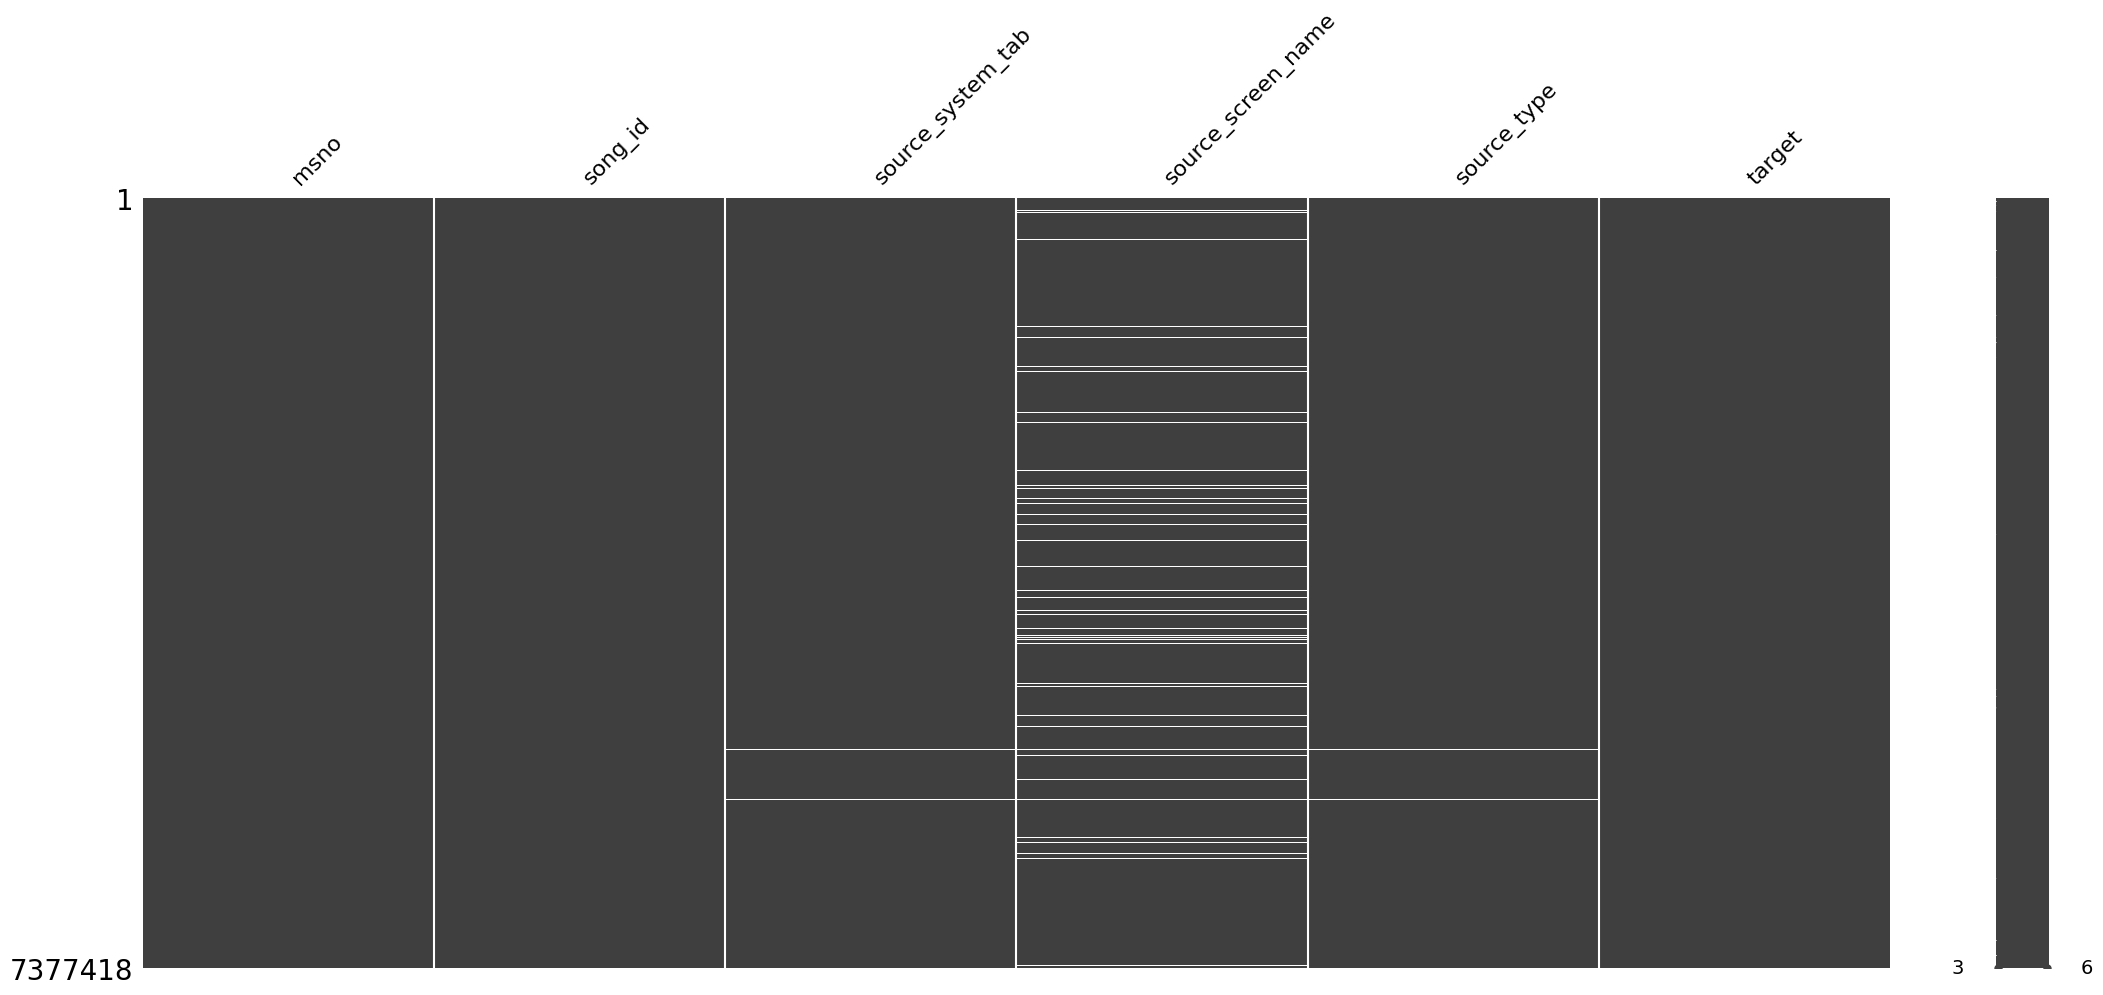

In [11]:
msno.matrix(train)

plt.show()

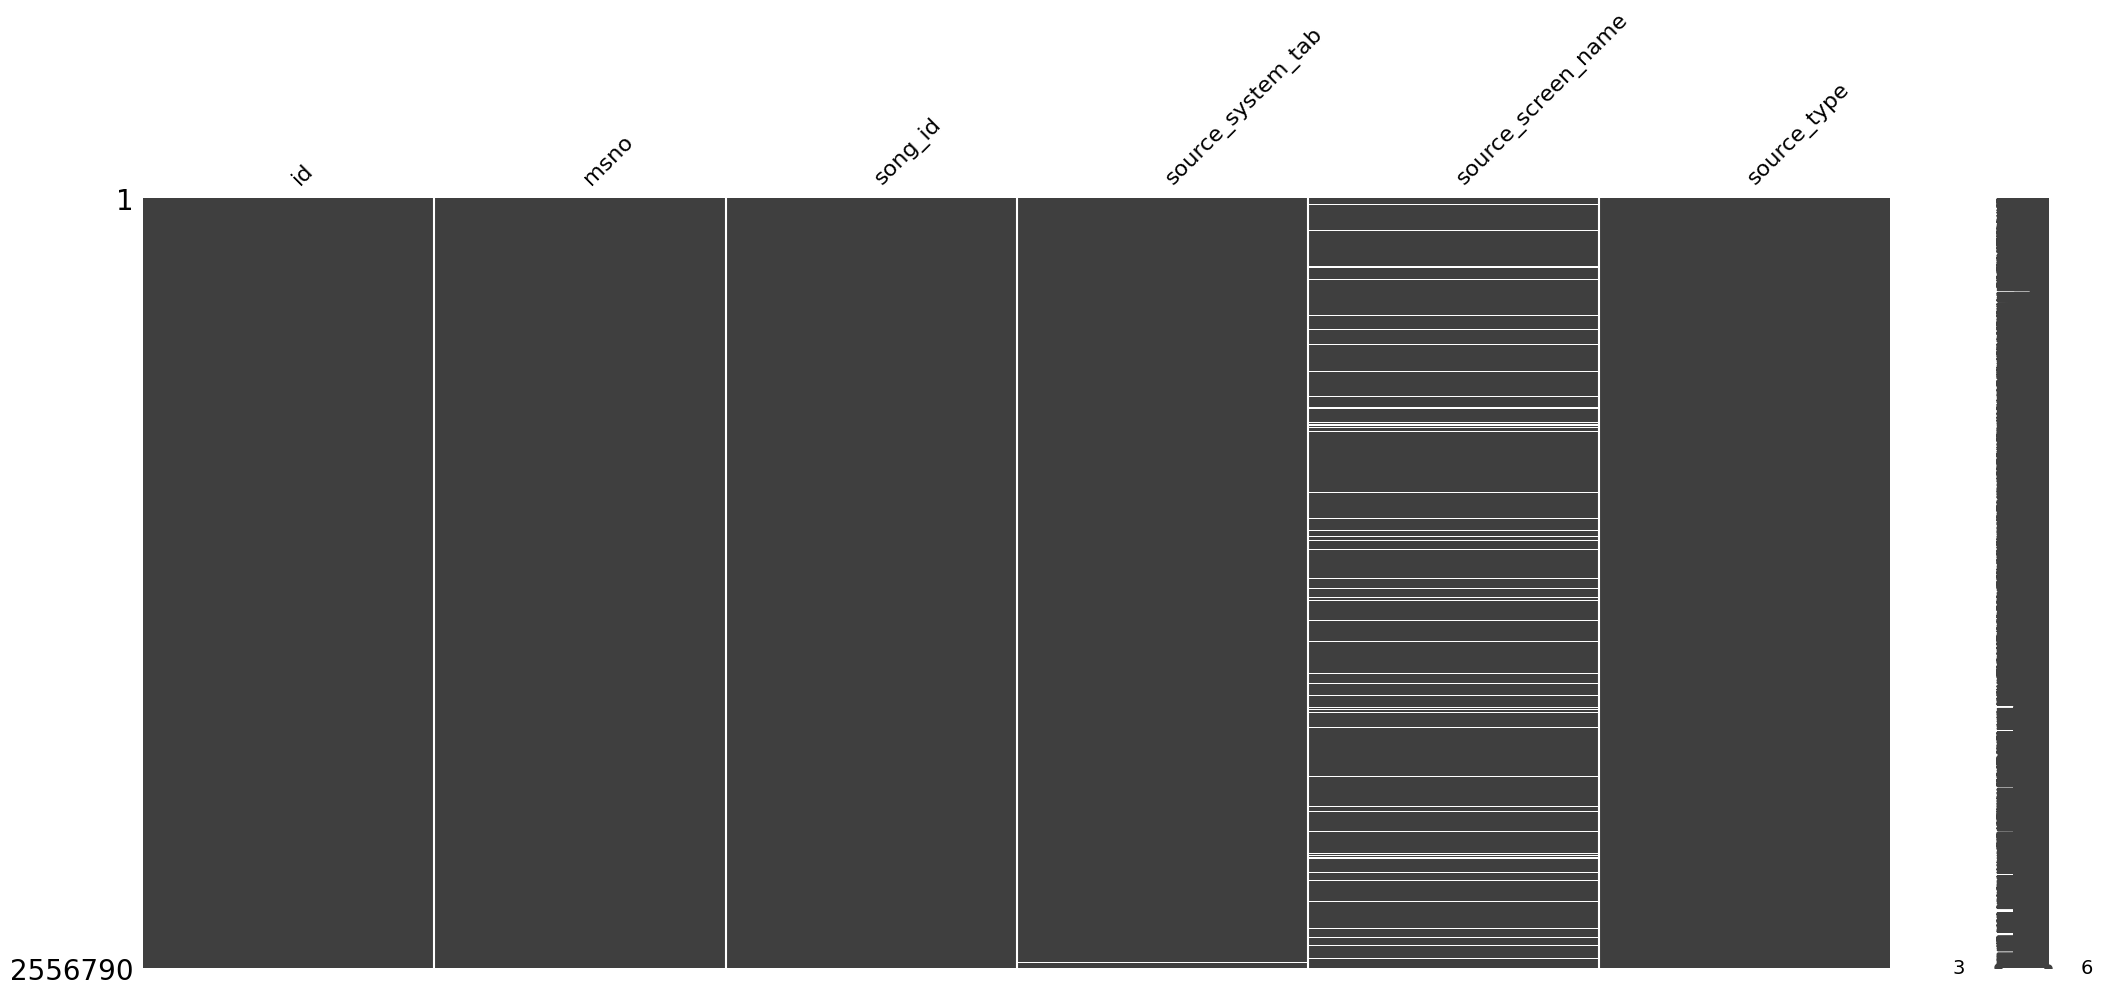

In [12]:
msno.matrix(test)

plt.show()

Пропущенных значений немного, в столбцах `source_system_tab` и `source_type` совсем немного пропусков (и это строки, где есть только `msno`, `song_id` и `target`, их можно удалить).

В `source_screen_name` достаточно много пропусков, каждый из них мы заменим на такое значение, которое чаще всего встречается с комбинацией из конкретных `source_system_tab` и `source_type`.

In [13]:
def most_common_screen_name(group):
    non_null_group = group.dropna()
    if non_null_group.empty:
        return None
    return non_null_group['source_screen_name'].value_counts().idxmax()

In [14]:
train = train.dropna(subset=['source_system_tab', 'source_type'])
test = test.dropna(subset=['source_system_tab', 'source_type'])

In [15]:
common_screen_names = train.groupby(['source_system_tab', 'source_type']).apply(most_common_screen_name).reset_index()
common_screen_names.columns = ['source_system_tab', 'source_type', 'most_common_screen_name']

train = train.merge(common_screen_names, on=['source_system_tab', 'source_type'], how='left')

train['source_screen_name'] = train.apply(
    lambda row: row['most_common_screen_name'] if pd.isnull(row['source_screen_name']) else row['source_screen_name'],
    axis=1
)

train = train.drop('most_common_screen_name', axis=1)

In [16]:
common_screen_names = test.groupby(['source_system_tab', 'source_type']).apply(most_common_screen_name).reset_index()
common_screen_names.columns = ['source_system_tab', 'source_type', 'most_common_screen_name']

test = test.merge(common_screen_names, on=['source_system_tab', 'source_type'], how='left')

test['source_screen_name'] = test.apply(
    lambda row: row['most_common_screen_name'] if pd.isnull(row['source_screen_name']) else row['source_screen_name'],
    axis=1
)

test = test.drop('most_common_screen_name', axis=1)

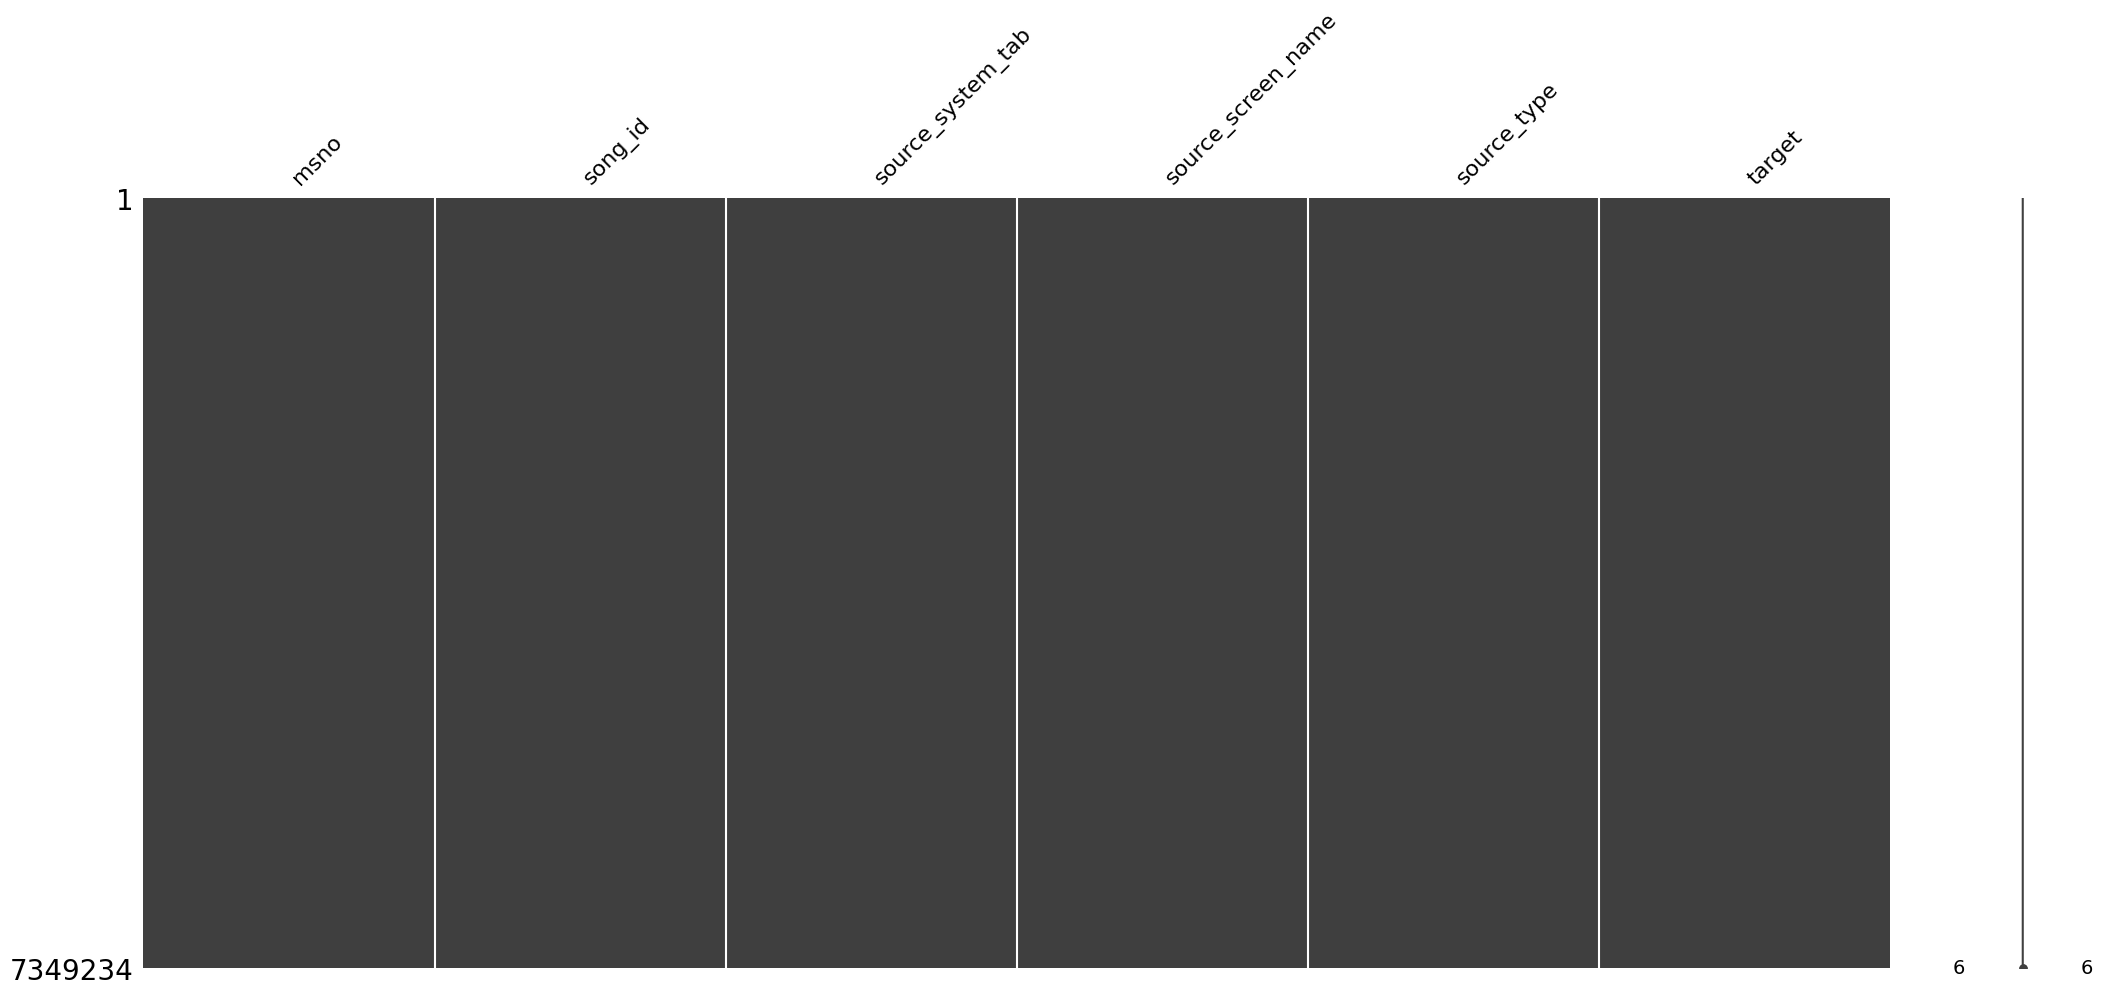

In [17]:
msno.matrix(train)

plt.show()

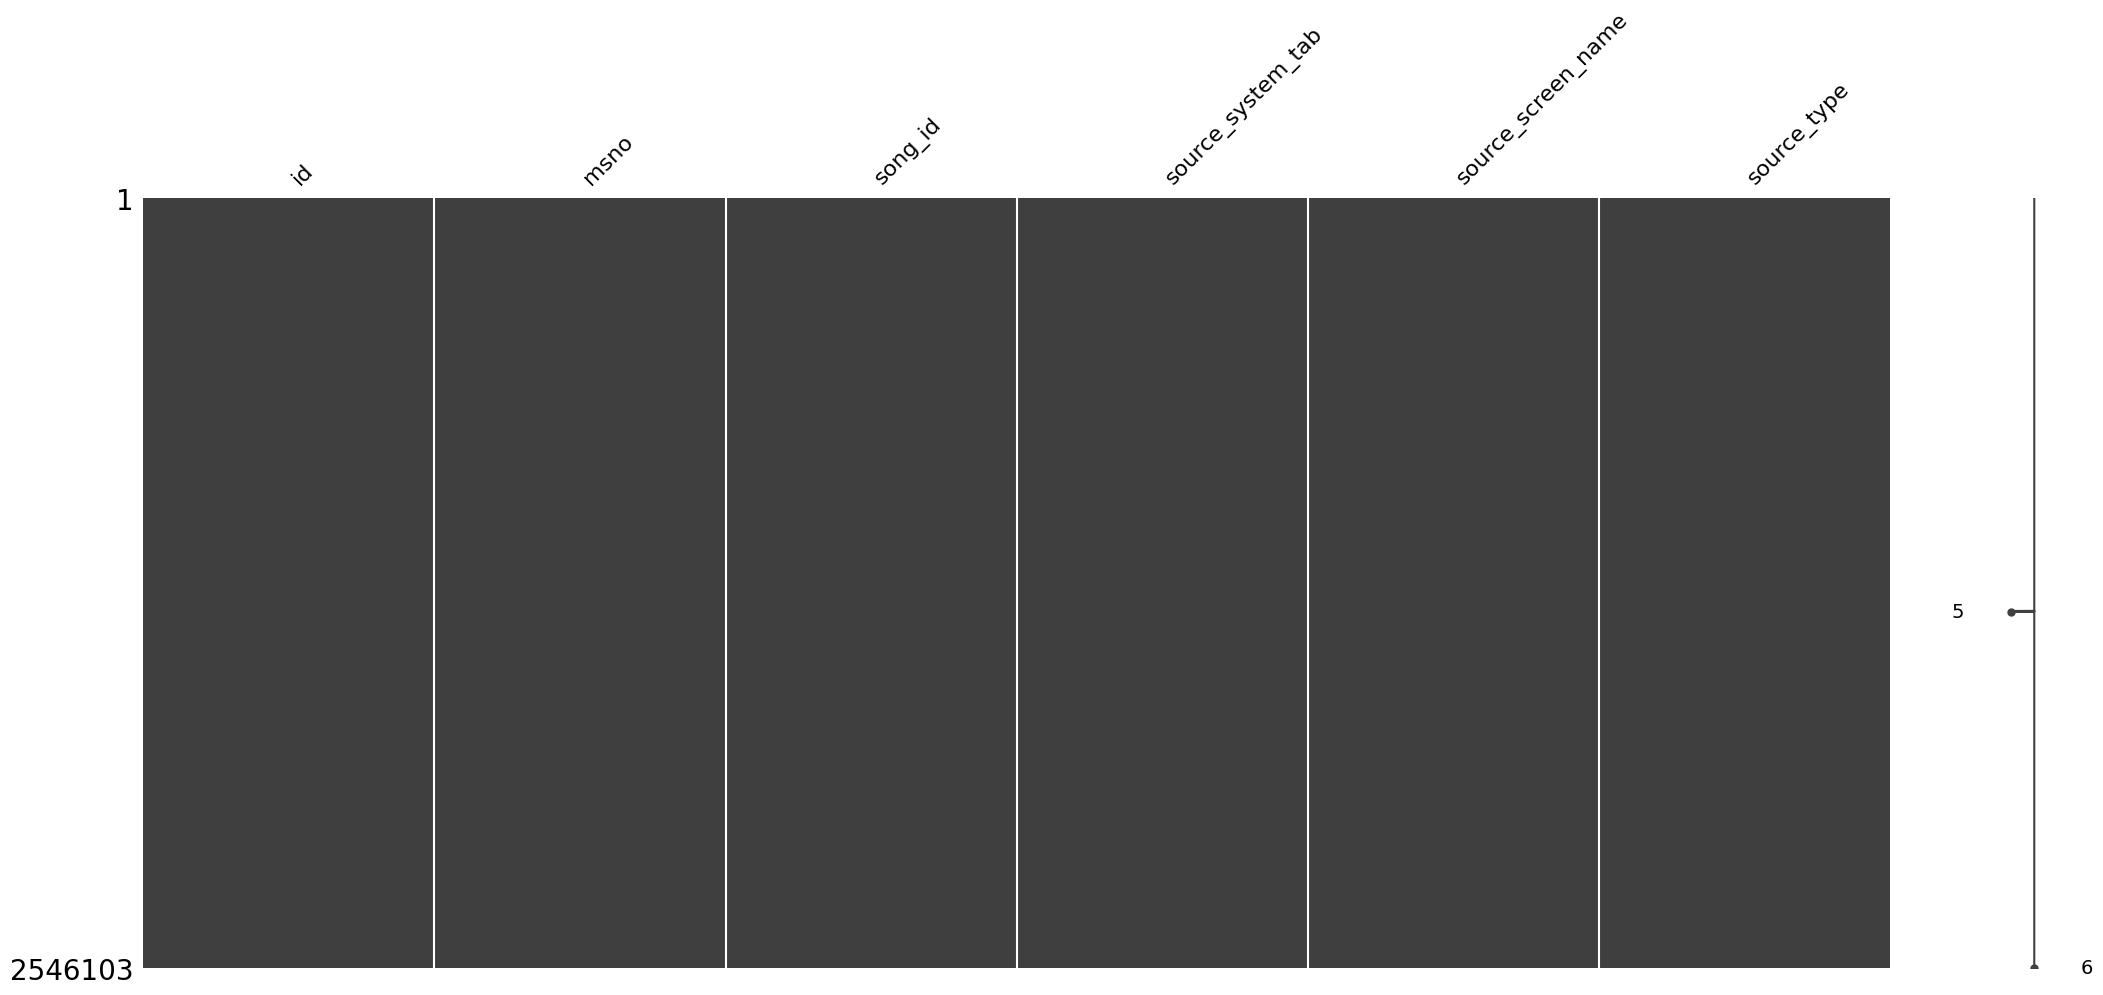

In [18]:
msno.matrix(test)

plt.show()

Пропусков больше нет, перейдём к дубликатам.

In [19]:
print(f'Initial shape: {train.shape}')
train.drop_duplicates(subset=['msno', 'song_id'], inplace=True)
print(f'Shape after dropping duplicates: {train.shape}')

Initial shape: (7349234, 6)
Shape after dropping duplicates: (7349234, 6)


In [20]:
print(f'Initial shape: {test.shape}')
test.drop_duplicates(subset=['msno', 'song_id'], inplace=True)
print(f'Shape after dropping duplicates: {test.shape}')

Initial shape: (2546103, 6)
Shape after dropping duplicates: (2546103, 6)


Дубликатов (то есть ситуаций, когда в разных строках один и тот же пользователь и одна и та же песня) не было.

Посмотрим на распределения признаков в датасете.

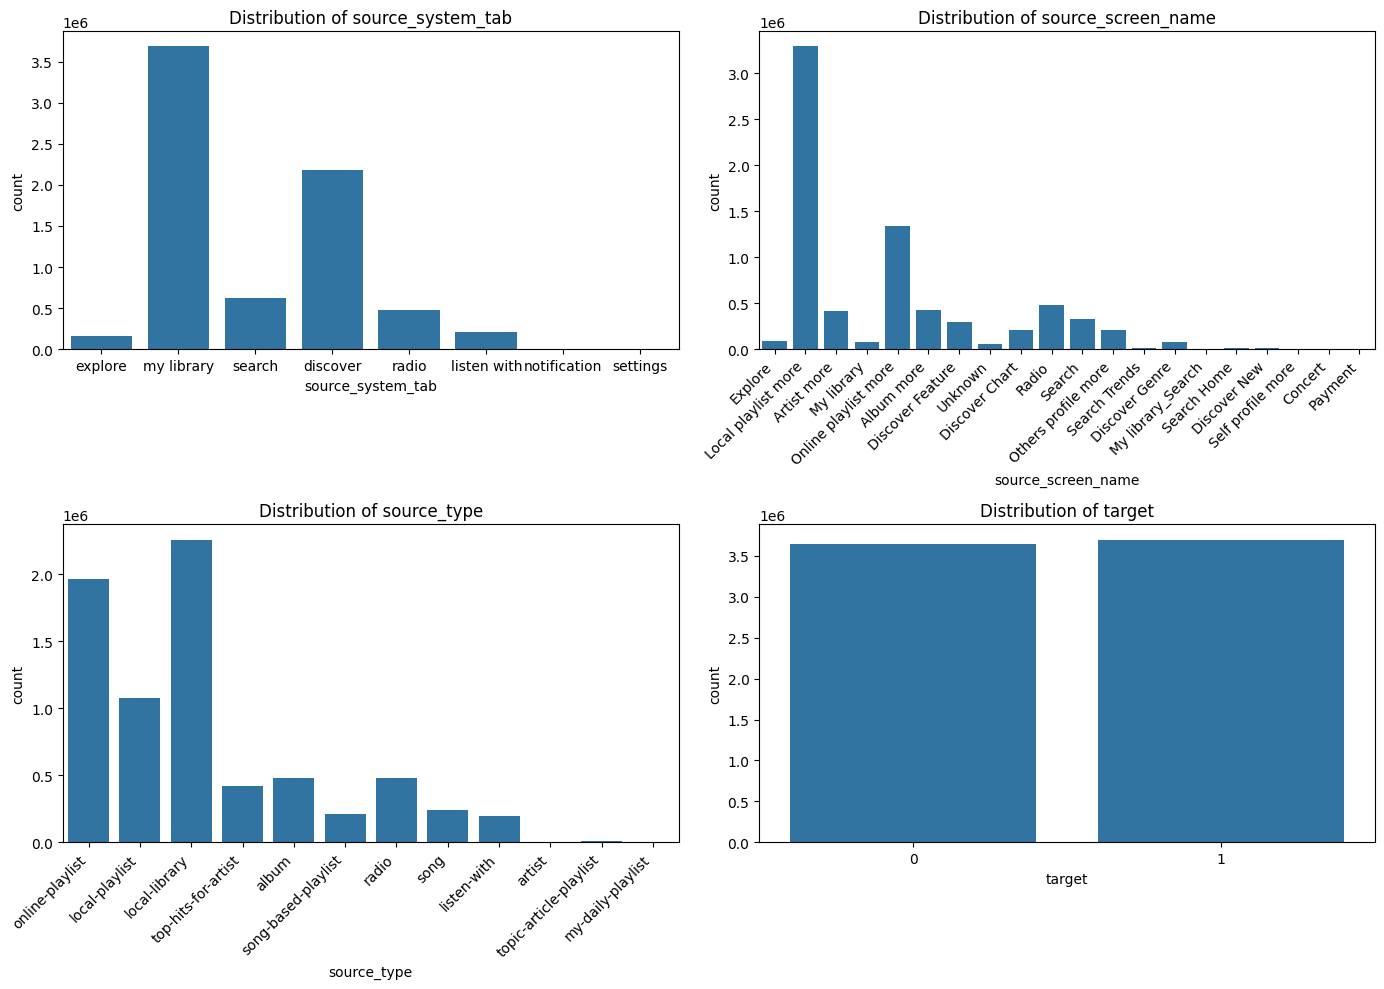

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

plot_0 = sns.countplot(x='source_system_tab', data=train, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of source_system_tab')


plot_1 = sns.countplot(x='source_screen_name', data=train, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of source_screen_name')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45, ha='right')


plot_2 = sns.countplot(x='source_type', data=train, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of source_type')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=45, ha='right')


plot_3 = sns.countplot(x='target', data=train, ax=axs[1, 1])
axs[1, 1].set_title('Distribution of target')


plt.tight_layout()
plt.show()


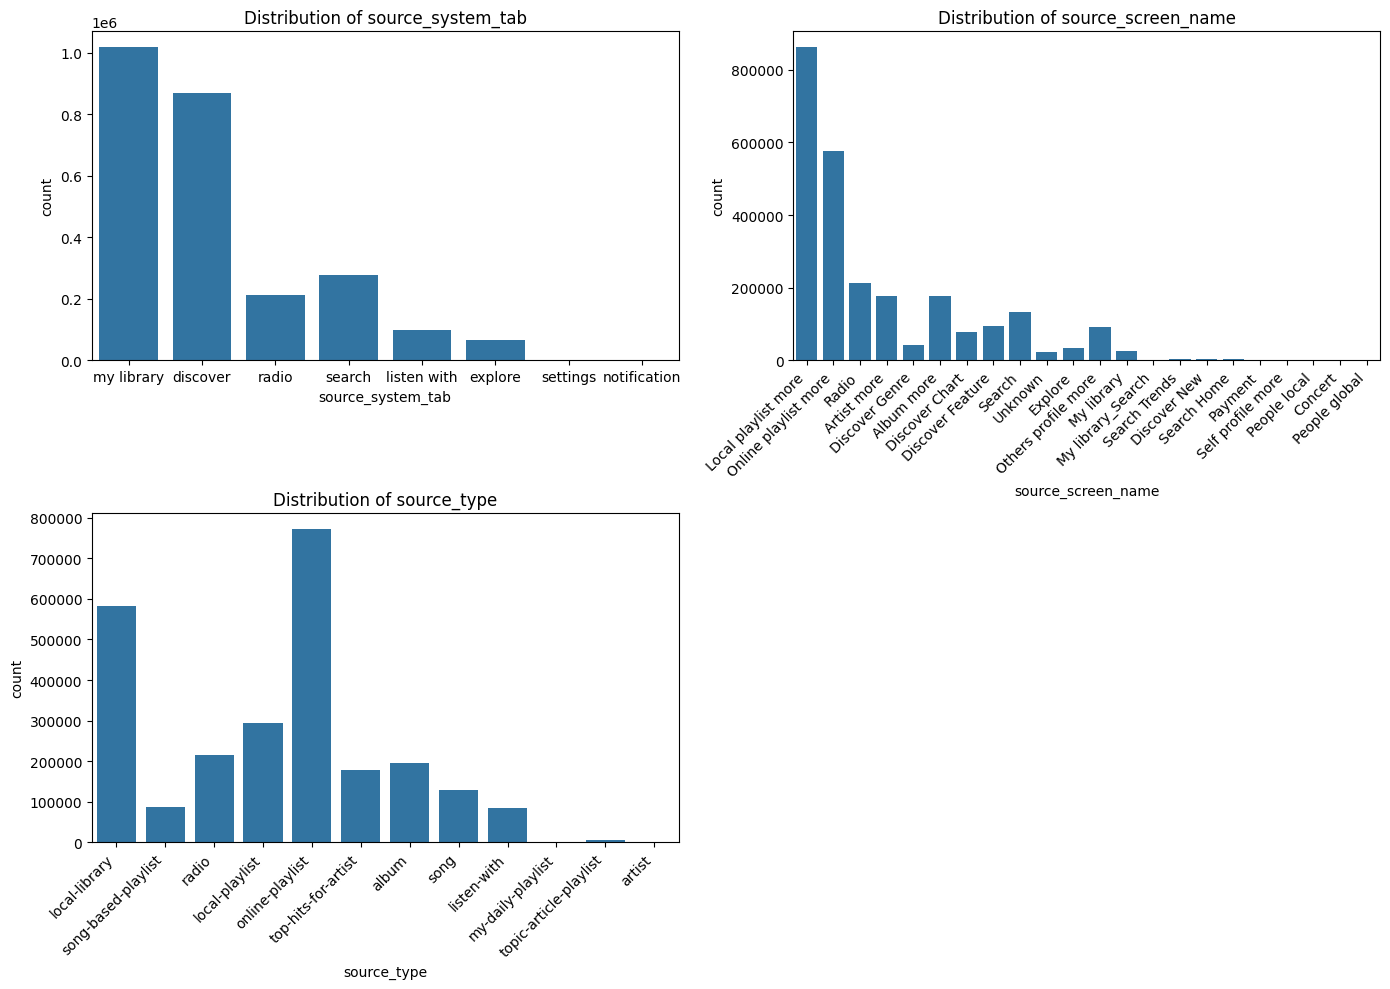

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

plot_0 = sns.countplot(x='source_system_tab', data=test, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of source_system_tab')


plot_1 = sns.countplot(x='source_screen_name', data=test, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of source_screen_name')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45, ha='right')


plot_2 = sns.countplot(x='source_type', data=test, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of source_type')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=45, ha='right')

axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


Значений с положительным и отрицательным таргетом почти поровну, в других же столбцах есть значения, которые практически совсем не встречаются (например, почти никто не слушает песни на вкладках `notification` и `settings`, а большинство слушает их из `my library`, очень мало кто включает песни определённого артиста с его страницы и из ежедневного плейлиста, хотя последнее достаточно контринтуитивно, но большинство - из локальной библиотеки или онлайн-плейлистов).

Можно увидеть много информации об использовании различных частей сервиса, но мы пока не можем делать железных выводов о том, на какой вкладке с большей вероятностью песню послушают (для этого нужно исследовать корреляцию с таргетом). По этим графикам мы можем только судить о популярности тех или иных разделов в приложении, и это практически не связано с треками.

Однако, можно считать выбросами следующие значения:

В "source_system_tab" : `notification`, `settings`;

В "source_screen_name" : `Search Trends`, `My library_Search`, `Search Home`, `Discover New`, `Unknown`, `Self profile more`, `Concert`, `Payment`, `People global` (некоторые значения встретились только в тестовом датафрейме);

В "source_type": `artist`, `topic-article-playlist`, `my-daily-playlist`.

Заменим эти выбросы на самое популярное значение в столбце.

In [23]:
most_common_system_tab = train['source_system_tab'].mode()[0]
most_common_screen_name = train['source_screen_name'].mode()[0]
most_common_source_type = train['source_type'].mode()[0]

outliers_system_tab = ['notification', 'settings']
outliers_screen_name = ['Search Trends', 'My library_Search', 'Search Home', 'Discover New', 'Unknown', 'Self profile more', 'Concert', 'Payment']
outliers_source_type = ['artist', 'topic-article-playlist', 'my-daily-playlist']

train['source_system_tab'] = train['source_system_tab'].apply(lambda x: most_common_system_tab if x in outliers_system_tab else x)
train['source_screen_name'] = train['source_screen_name'].apply(lambda x: most_common_screen_name if x in outliers_screen_name else x)
train['source_type'] = train['source_type'].apply(lambda x: most_common_source_type if x in outliers_source_type else x)


In [24]:
most_common_system_tab = test['source_system_tab'].mode()[0]
most_common_screen_name = test['source_screen_name'].mode()[0]
most_common_source_type = test['source_type'].mode()[0]

outliers_system_tab = ['notification', 'settings']
outliers_screen_name = ['Search Trends', 'My library_Search', 'Search Home',
                        'Discover New', 'Unknown', 'Self profile more', 'Concert', 'Payment', 'People global', 'People local']
outliers_source_type = ['artist', 'topic-article-playlist', 'my-daily-playlist']

test['source_system_tab'] = test['source_system_tab'].apply(lambda x: most_common_system_tab if x in outliers_system_tab else x)
test['source_screen_name'] = test['source_screen_name'].apply(lambda x: most_common_screen_name if x in outliers_screen_name else x)
test['source_type'] = test['source_type'].apply(lambda x: most_common_source_type if x in outliers_source_type else x)


Посмотрим на распределение ещё раз.

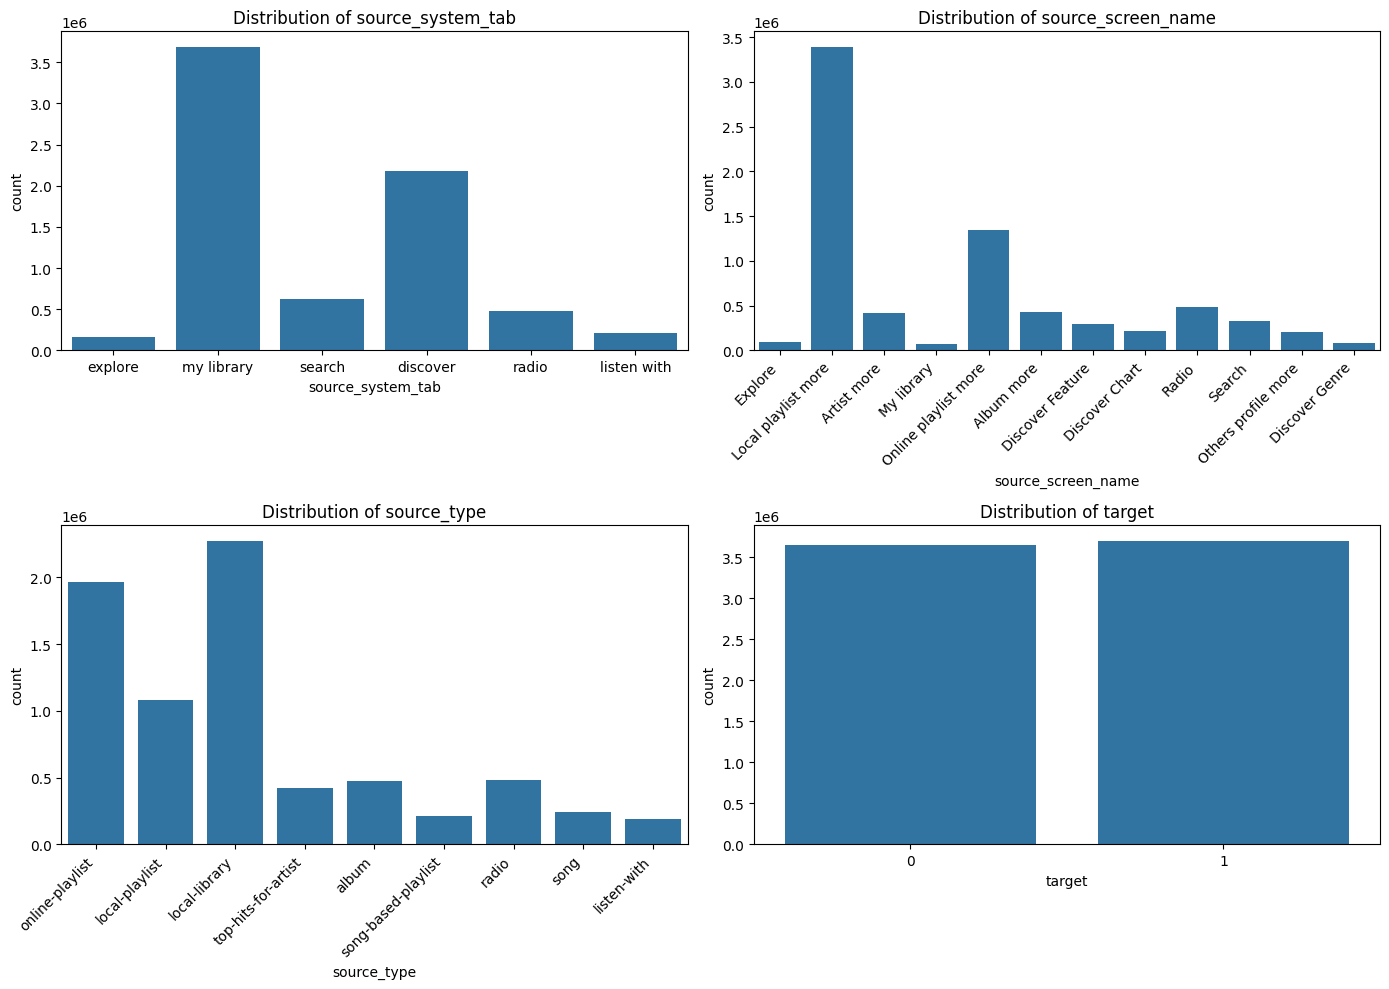

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

plot_0 = sns.countplot(x='source_system_tab', data=train, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of source_system_tab')


plot_1 = sns.countplot(x='source_screen_name', data=train, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of source_screen_name')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45, ha='right')


plot_2 = sns.countplot(x='source_type', data=train, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of source_type')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=45, ha='right')


plot_3 = sns.countplot(x='target', data=train, ax=axs[1, 1])
axs[1, 1].set_title('Distribution of target')


plt.tight_layout()
plt.show()


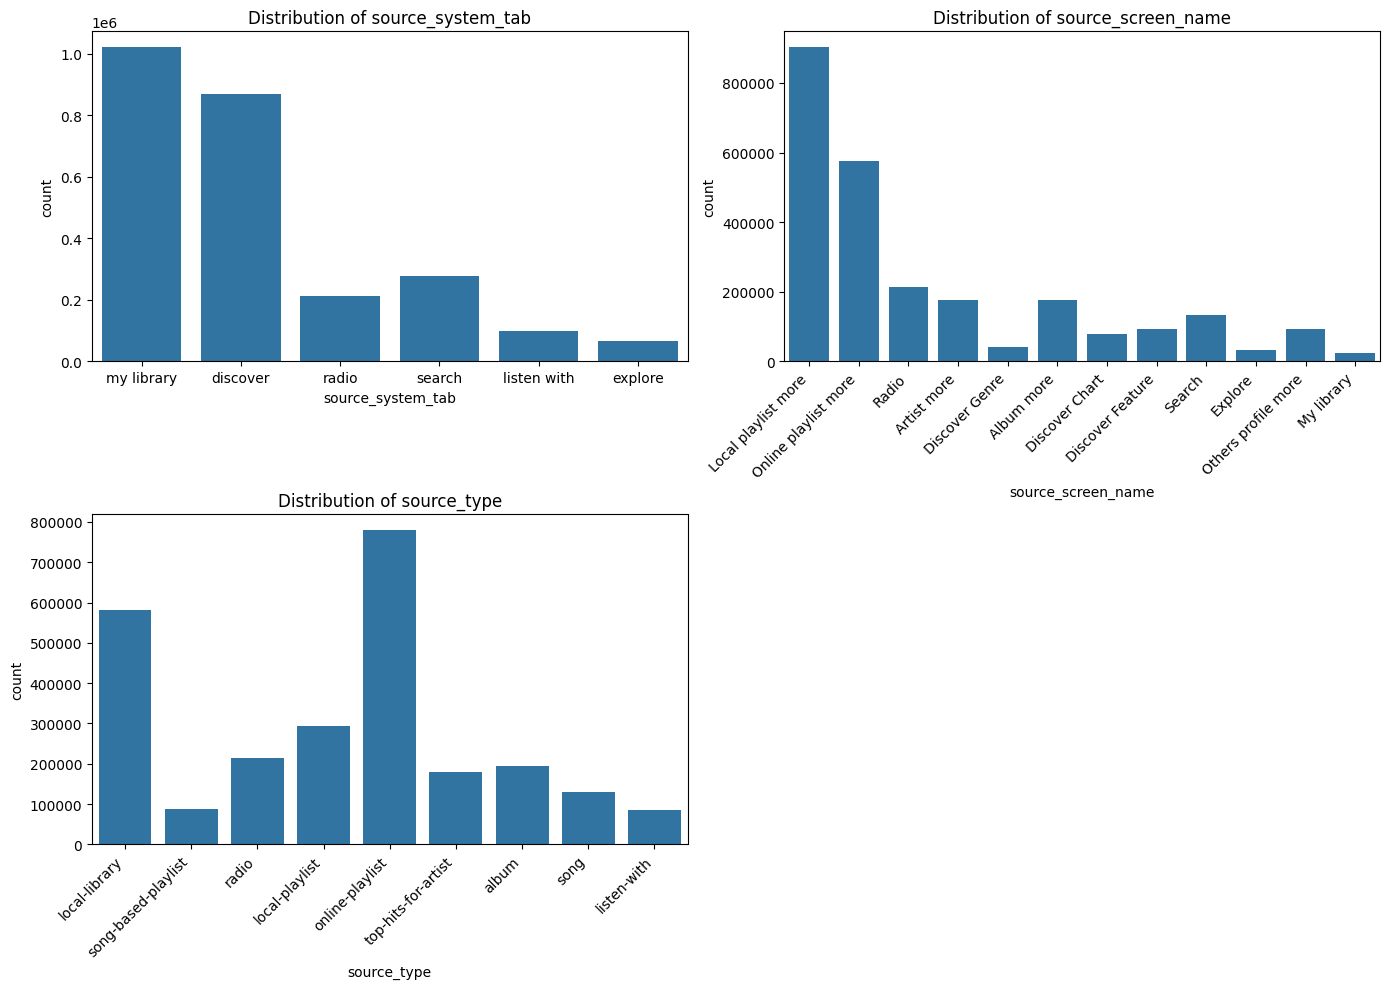

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

plot_0 = sns.countplot(x='source_system_tab', data=test, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of source_system_tab')


plot_1 = sns.countplot(x='source_screen_name', data=test, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of source_screen_name')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45, ha='right')


plot_2 = sns.countplot(x='source_type', data=test, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of source_type')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=45, ha='right')

axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


У нас больше нет выбросов в датасете. Теперь сделаем label encoding и посмотрим на корреляционную матрицу.

<Axes: >

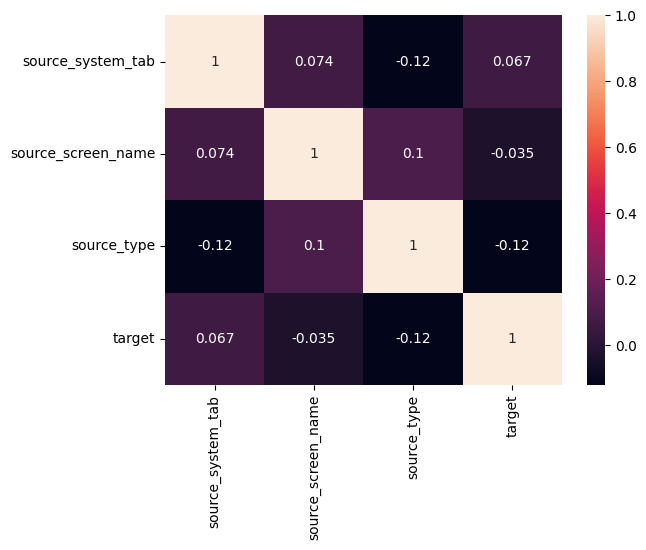

In [27]:
label_encoder = LabelEncoder()

train['source_system_tab'] = label_encoder.fit_transform(train['source_system_tab'].astype(str))
train['source_screen_name'] = label_encoder.fit_transform(train['source_screen_name'].astype(str))
train['source_type'] = label_encoder.fit_transform(train['source_type'].astype(str))
train['target'] = train['target']

correlation_matrix = train.drop(columns=['msno', 'song_id']).corr(method='pearson')

sns.heatmap(correlation_matrix, annot=True)

In [28]:
label_encoder = LabelEncoder()

test['source_system_tab'] = label_encoder.fit_transform(test['source_system_tab'].astype(str))
test['source_screen_name'] = label_encoder.fit_transform(test['source_screen_name'].astype(str))
test['source_type'] = label_encoder.fit_transform(test['source_type'].astype(str))


В этом датафрейме никакие два столбца значимо друг с другом не коррелируют.

## Members

In [29]:
members.head(3)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712


In [30]:
print('Unique Values in Columns:\n\n')

print(f"city:\n{members['city'].unique()}\n\n")
print(f"gender:\n{members['gender'].unique()}\n\n")
print(f"bd:\n{members['bd'].unique()}\n\n")
print(f"registered_via:\n{members['registered_via'].unique()}")

Unique Values in Columns:


city:
[ 1 13 12 15  5  6  4 11 18 22 14  8 20  3 17 10 16  9 21  7 19]


gender:
[nan 'female' 'male']


bd:
[   0   43   28   33   20   30   29   26   25   21   22   16   23   37
   18   19   51   24   17   45   36   57   27   34   32   15   48   50
   54   47   35   46   31   14   41   59    2   40   38   55   39   73
   49   44  103   52   70   42   65   56  101   58   53   64   63   76
   66   97    3   72   67   62   61  105   60   13   90   12   68  131
   74   89  931  -38  144   85  112   96   11  102   83 1051   87    7
   95  -43  111   93    5   78 1030  106  107   82   10]


registered_via:
[ 7  4  9  3 13 16]


Пропуски есть только в гендере, выбросы только в возрасте. Будем обрабатывать две этих колонки, две другие трогать не будем (их даже не нужно никак кодировать).

Даты представлены в формате YYMMDD, с таким работать крайне неудобно. Разделим каждую из дат (registration_init_time и expiration_date) на три столбца с годом, месяцем и днём.

Также применим one hot encoding к гендеру после предобработки.

\

Первым делом посмотрим на дубликаты `msno` и пропуски. Дубликаты просто удалим, а пропуски в гендере заполним.

In [31]:
print(f'Initial shape: {members.shape}')
members.drop_duplicates(subset=['msno'], inplace=True)
print(f'Shape after dropping duplicates: {members.shape}')

Initial shape: (34403, 7)
Shape after dropping duplicates: (34403, 7)


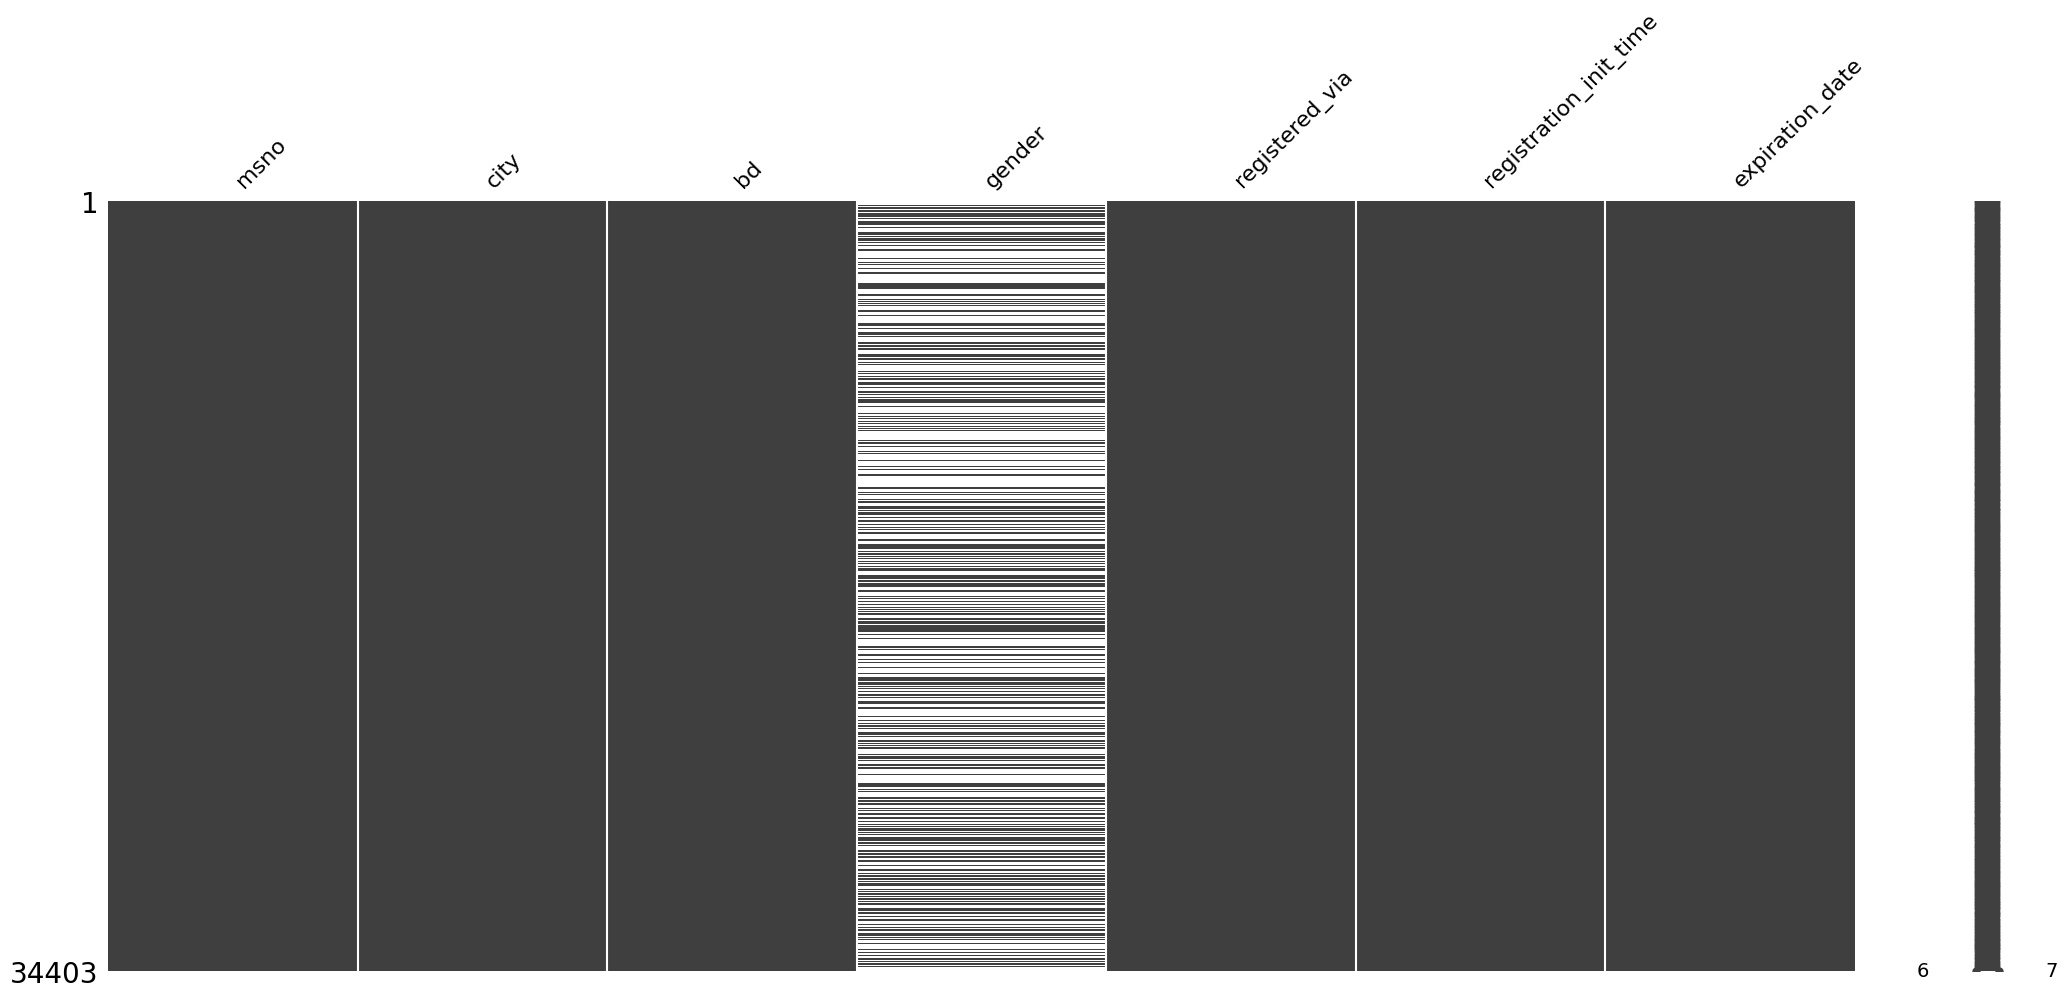

In [32]:
msno.matrix(members)

plt.show()

In [33]:
print(f'Percent of missing genders: {members.gender.isnull().sum() / members.shape[0] * 100}%')

Percent of missing genders: 57.84960613899951%


<Axes: xlabel='gender', ylabel='count'>

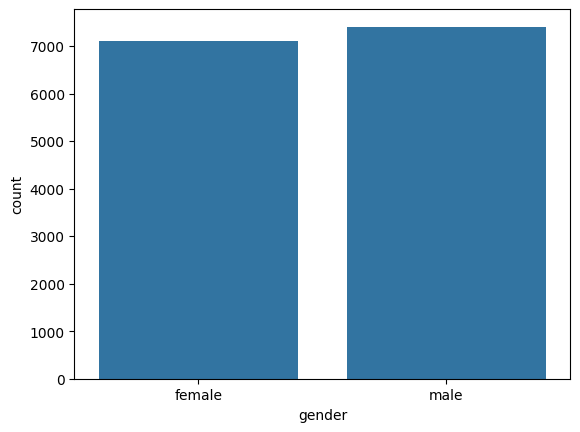

In [34]:
sns.countplot(x='gender', data=members)

В гендере неприлично много пропусков (больше половины). Это не позволяет нам делать релевантные выводы о том, как их заполнить значениями male или female.
Так как мужчин и женщин в выборке почти одинаковое количество, не совсем корректно будет заменять недостающие значения на самое популярное.

Можно заполнять пол случайным образом, а можно указать во всех пустых ячейках "not provided", также можно совсем удалить колонку `gender`.

Правильнее всего в данном случае будет заменить на "not provided", а после feature engineering попробовать восстановить пол по значениям из других датафреймов.

In [35]:
members['gender'].fillna('not_provided', inplace=True)

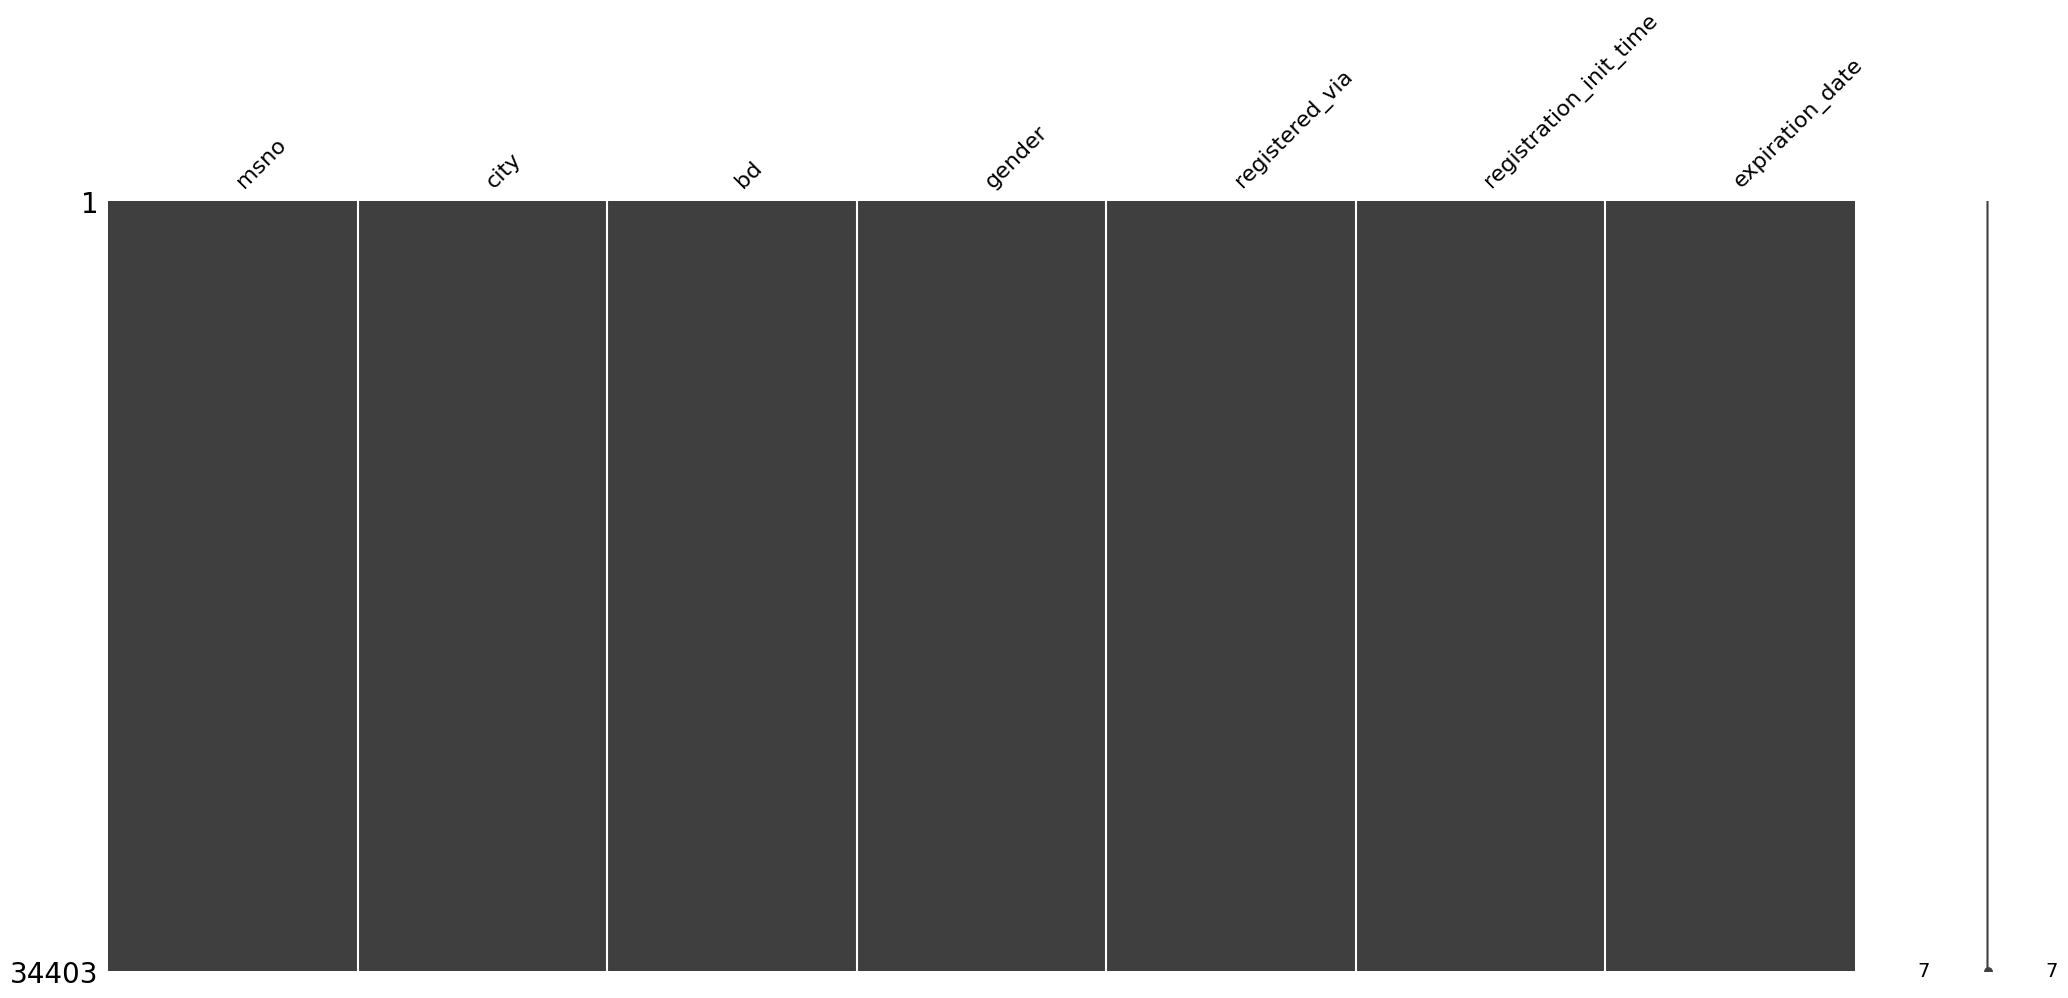

In [36]:
msno.matrix(members)

plt.show()

Теперь разберёмся с выбросами возраста и даты (последние будем искать после разделения на колонки).

Сначала обрежем очень явные (те, которые меньше 0 и больше 100), затем посмотрим на остальные значения и примем решение, что ещё является выбросом.

In [37]:
members.loc[members['bd'] < 1, 'bd'] = np.nan
members.loc[members['bd'] > 100, 'bd'] = np.nan

In [38]:
members.bd.isnull().sum()

19956

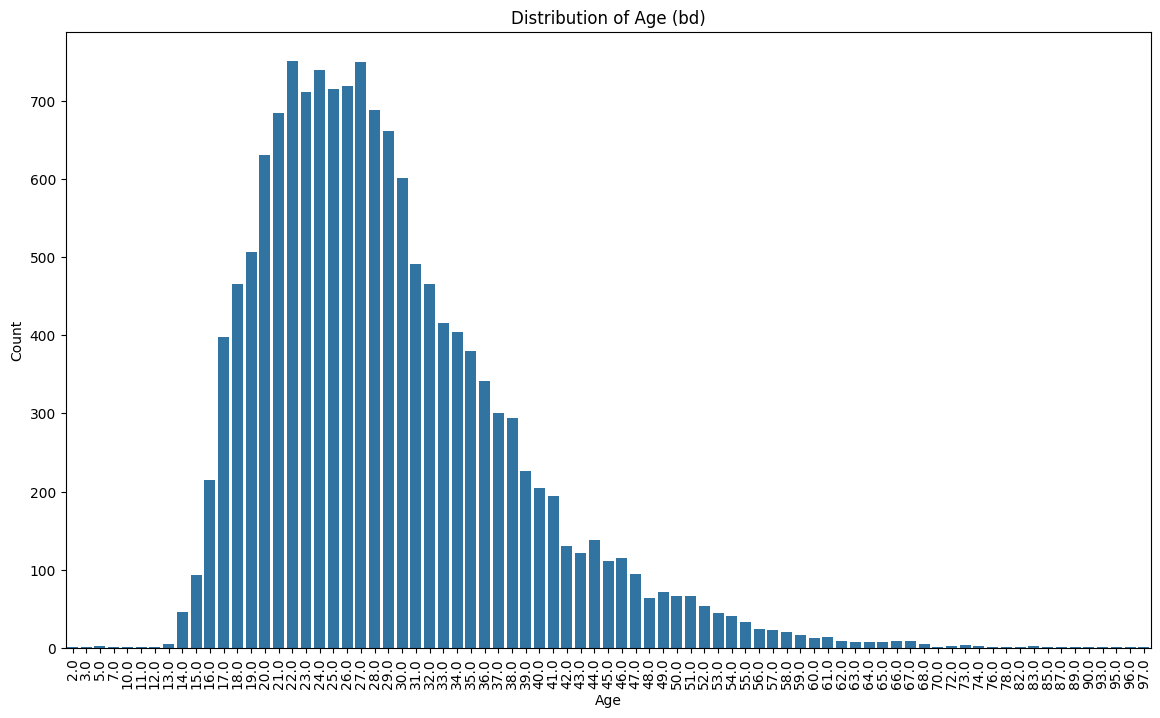

In [39]:
plt.figure(figsize=(14, 8))
ax = sns.countplot(data=members, x='bd')
plt.title('Distribution of Age (bd)')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Судя по всему, минимальное разумное значение, которое стоит брать - 14 лет, максимальное - 70.

In [40]:
members.loc[members['bd'] < 14, 'bd'] = np.nan
members.loc[members['bd'] > 70, 'bd'] = np.nan

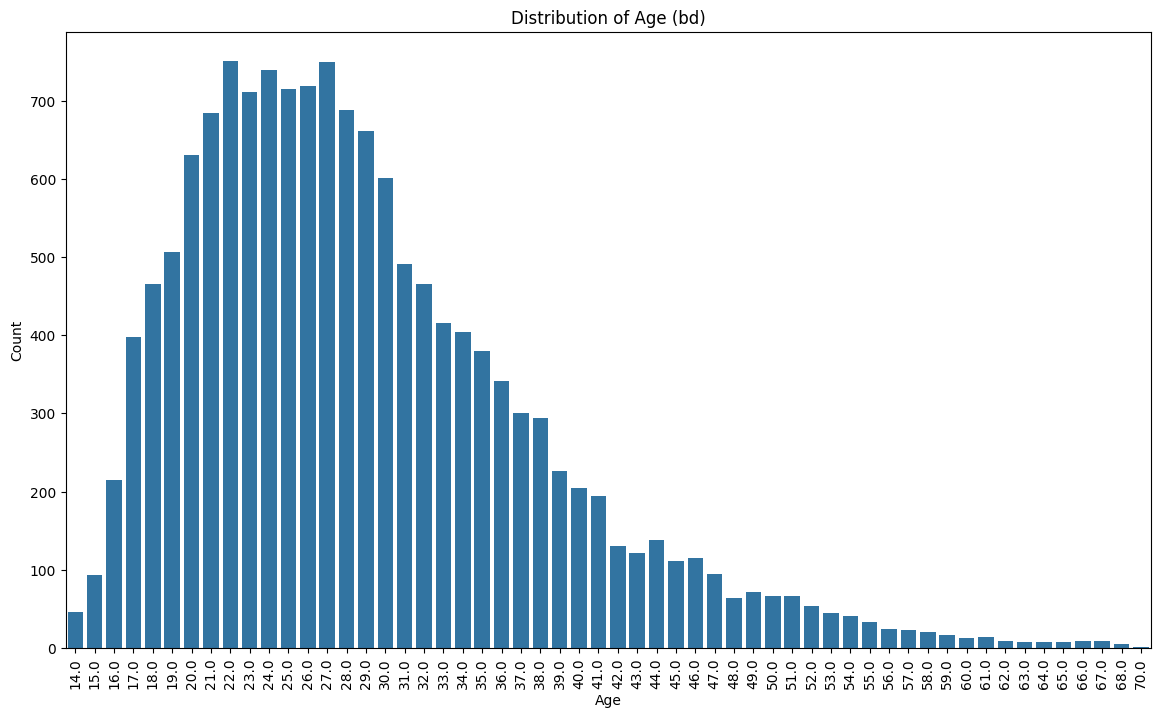

In [41]:
plt.figure(figsize=(14, 8))
ax = sns.countplot(data=members, x='bd')
plt.title('Distribution of Age (bd)')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [42]:
members.bd.isnull().sum()

19991

In [43]:
members.bd.notnull().sum()

14412

Пустых значений больше половины, поэтому на моду или медиану возраста заменять не очень правильно.

Найдём эмпирическую функцию распределения возраста и будем заменять пропуски на случайные целые величины из этого распределения.

In [44]:
def sample_value(n_samples, distribution):
    return np.random.choice(distribution.index, size=n_samples, p=distribution.values)

In [45]:
bd_distribution = members['bd'].dropna().value_counts(normalize=True)

n_missing_bds = members['bd'].isnull().sum()

members.loc[members['bd'].isnull(), 'bd'] = sample_value(n_missing_bds, bd_distribution)

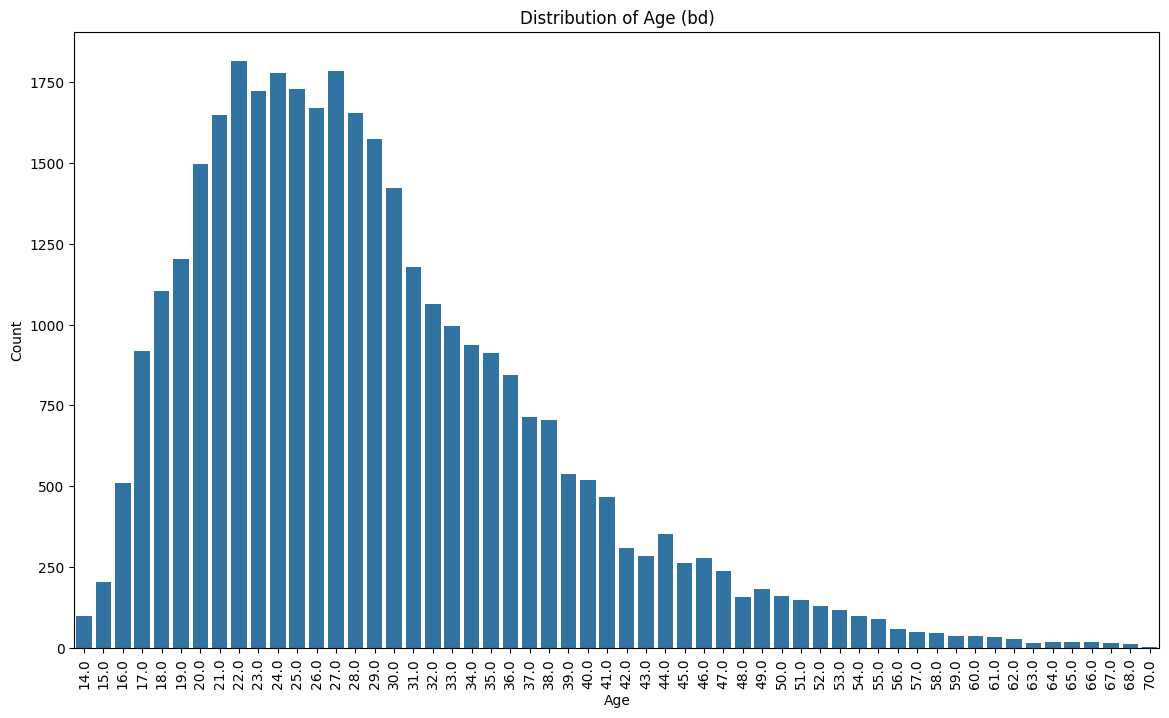

In [46]:
plt.figure(figsize=(14, 8))
ax = sns.countplot(data=members, x='bd')
plt.title('Distribution of Age (bd)')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [47]:
members['bd'] = members['bd'].astype('int')

Теперь возраст выглядит значительно правдоподобнее, и распределение не испортилось.

Посмотрим теперь на распределения остальных колонок (`city`, `registered_via`).

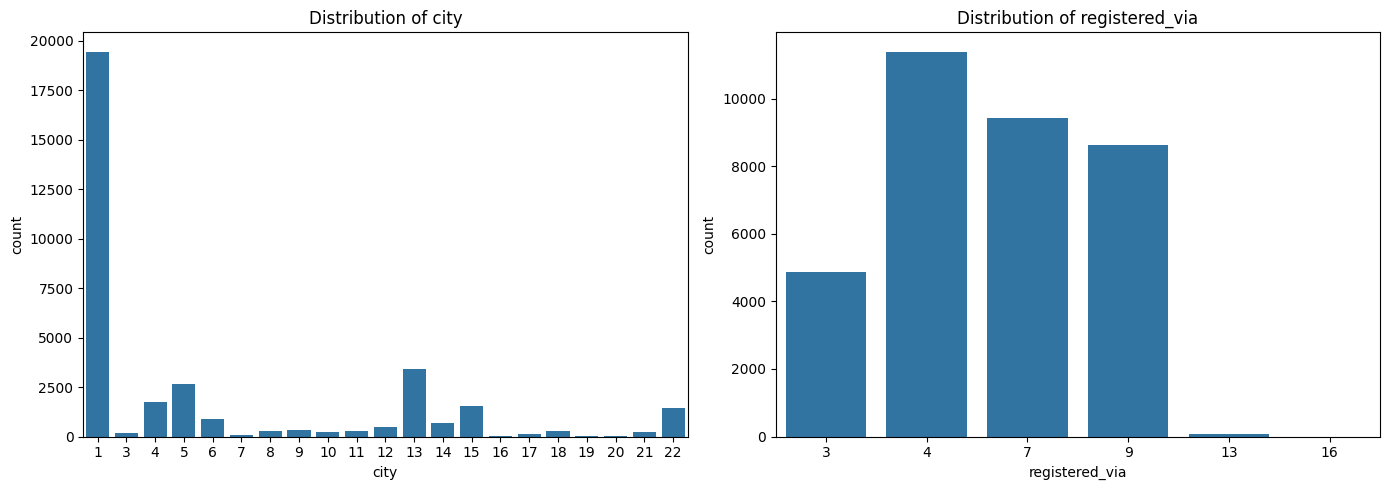

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

plot_0 = sns.countplot(x='city', data=members, ax=axs[0])
axs[0].set_title('Distribution of city')


plot_1 = sns.countplot(x='registered_via', data=members, ax=axs[1])
axs[1].set_title('Distribution of registered_via')


plt.tight_layout()
plt.show()


В этих двух колонках достаточно много выбросов.

В `city` это 7, 16, 17, 19, 20.

В `registered_via` это 13 и 16.

Заменим на моду каждого из столбцов.

In [49]:
city_mode = members['city'].mode()[0]
registered_via_mode = members['registered_via'].mode()[0]

outliers_city = [7, 16, 17, 19, 20]
members.loc[members['city'].isin(outliers_city), 'city'] = city_mode

outliers_registered_via = [13, 16]
members.loc[members['registered_via'].isin(outliers_registered_via), 'registered_via'] = registered_via_mode

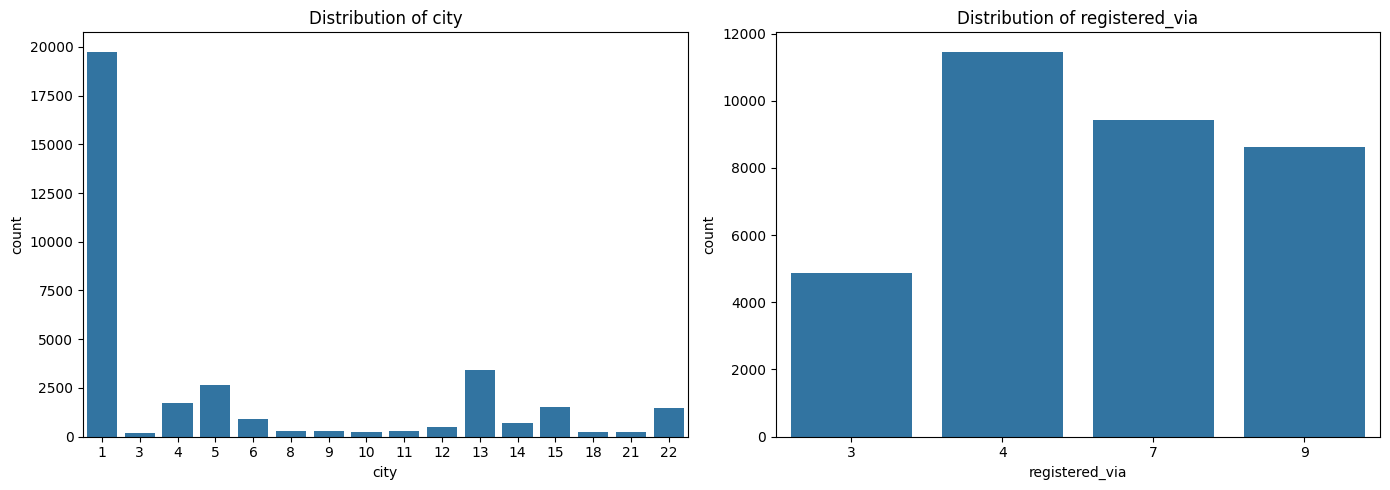

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

plot_0 = sns.countplot(x='city', data=members, ax=axs[0])
axs[0].set_title('Distribution of city')


plot_1 = sns.countplot(x='registered_via', data=members, ax=axs[1])
axs[1].set_title('Distribution of registered_via')


plt.tight_layout()
plt.show()


Обработаем теперь даты.

Возможно, есть какая-то закономерность в том, сколько времени проходит от дня регистрации до срока истечения аккаунта, и мы сможем найти выборсы таким образом. Посмотрим на распределение этого показателя.

In [51]:
members['registration_init_time'] = pd.to_datetime(members['registration_init_time'], format='%Y%m%d')
members['expiration_date'] = pd.to_datetime(members['expiration_date'], format='%Y%m%d')

members['duration'] = (members['expiration_date'] - members['registration_init_time']).dt.days

In [52]:
members.loc[members['duration'] < 0, 'duration'] = np.nan

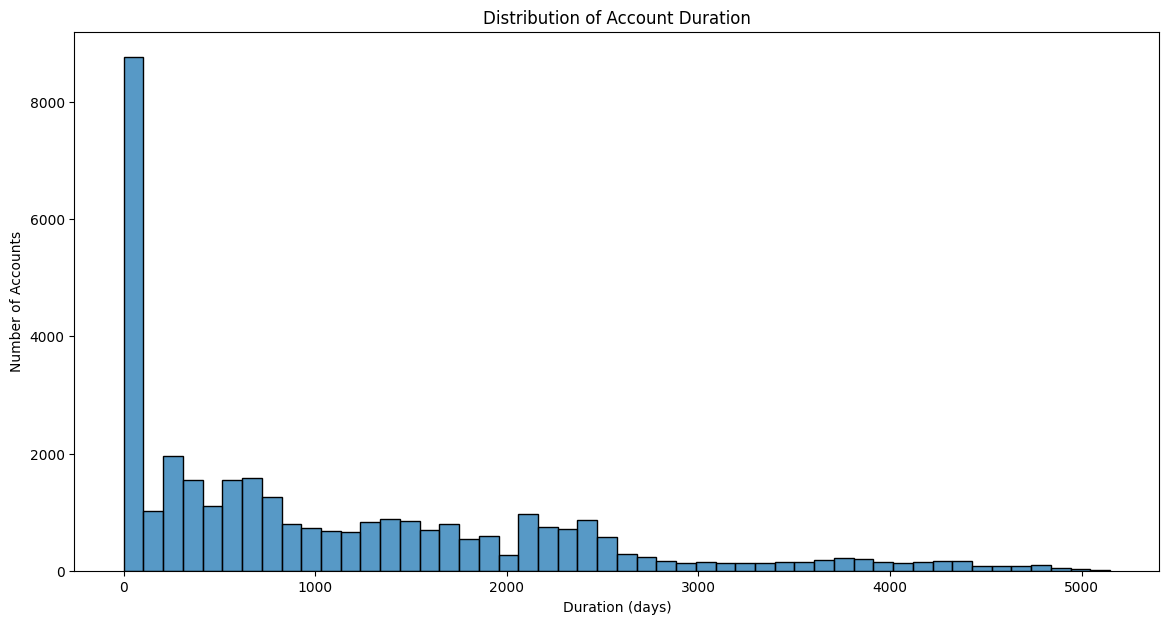

In [53]:
plt.figure(figsize=(14, 7))
sns.histplot(members['duration'], bins=50)
plt.title('Distribution of Account Duration')
plt.xlabel('Duration (days)')
plt.ylabel('Number of Accounts')
plt.show()

График очень странный - большинство аккаунтов истекает через 0-50 дней после регистрации, некоторые же - больше чем через 10 лет. Кажется, что здесь точно есть выбросы.

Попробуем убрать все значения, которые меньше 51 дня и больше 2500 дней.

In [54]:
members.loc[members['duration'] < 51, 'duration'] = np.nan
members.loc[members['duration'] > 2500, 'duration'] = np.nan

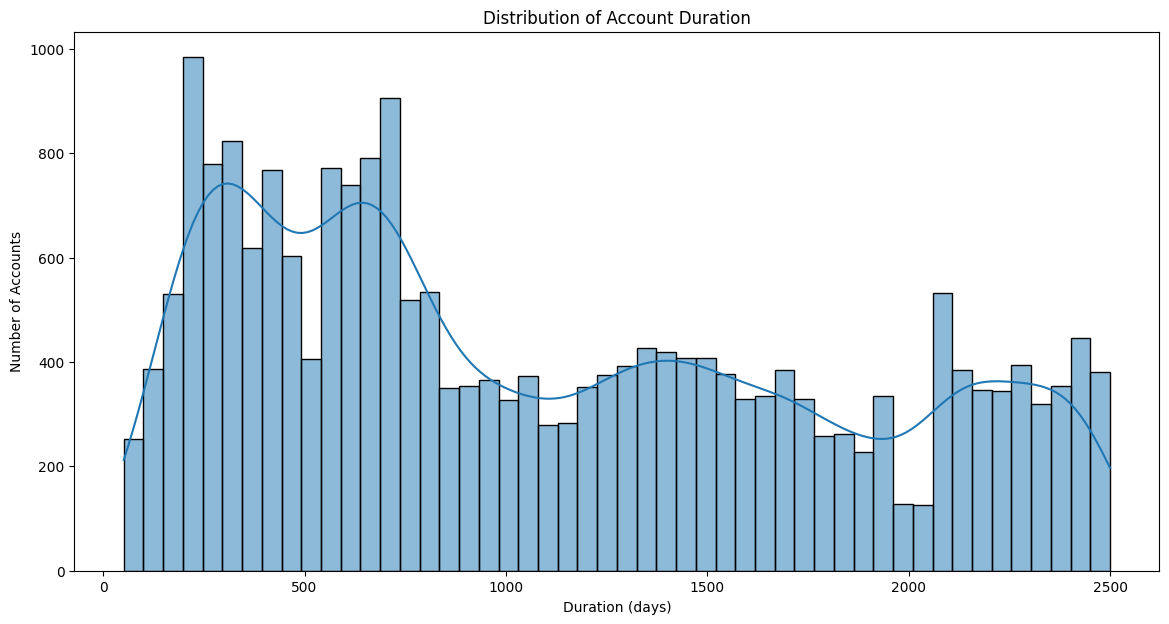

In [55]:
plt.figure(figsize=(14, 7))
sns.histplot(members['duration'], bins=50, kde=True)
plt.title('Distribution of Account Duration')
plt.xlabel('Duration (days)')
plt.ylabel('Number of Accounts')
plt.show()

Распределение стало совсем другим, но оно всё равно довольно странное. Можно сделать предположение, что аккаунт блокируется после какого-то определённого времени, в течение которого пользователь ни разу не заходит в приложение. Всё, что мы можем сделать в этой ситуации - сохранить распределение.

Давайте заполним пропуски, а потом будем восстанавливать по длительности и одной из дат (которую посчитаем правдоподобнее) вторую дату.

In [56]:
duration_distribution = members['duration'].dropna().value_counts(normalize=True)

n_missing_durs = members['duration'].isnull().sum()

members.loc[members['duration'].isnull(), 'duration'] = sample_value(n_missing_durs, duration_distribution)

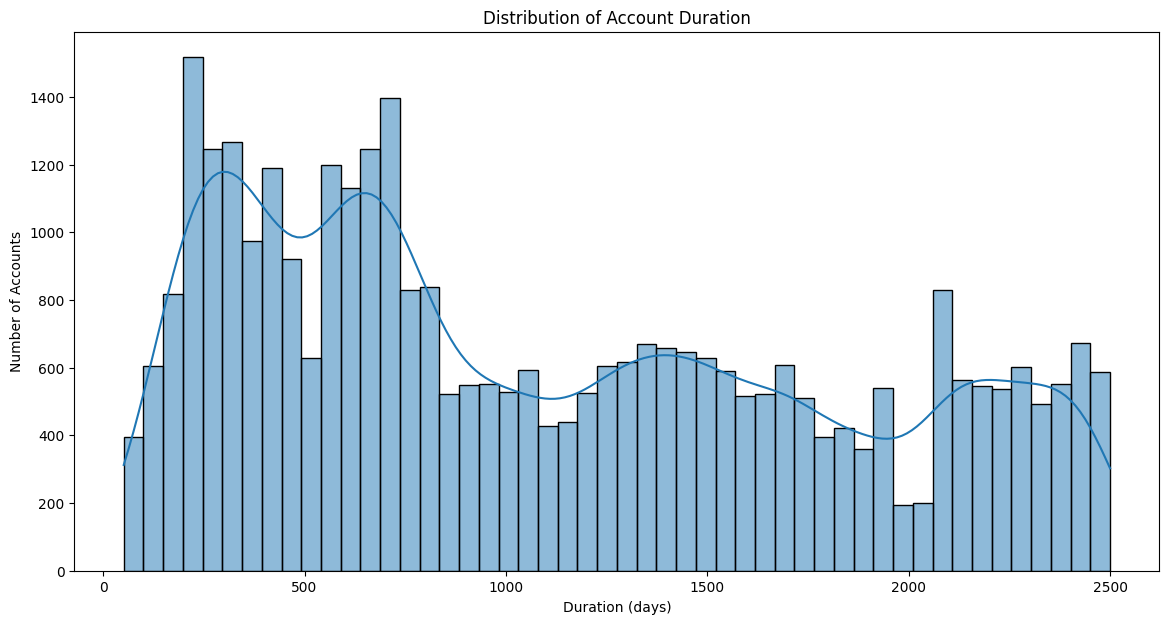

In [57]:
plt.figure(figsize=(14, 7))
sns.histplot(members['duration'], bins=50, kde=True)
plt.title('Distribution of Account Duration')
plt.xlabel('Duration (days)')
plt.ylabel('Number of Accounts')
plt.show()

Распределение по форме осталось таким же, пропуски заполнены.
Теперь посмотрим на каждую из дат и решим, какие наиболее похожи на правду - даты регистрации или даты истечения.

Для этого придётся разбить колонки с датами на три каждую, потому что намного проще проверять адекватность дат по годам.

In [58]:
members['registration_year'] = members['registration_init_time'].dt.year
members['registration_month'] = members['registration_init_time'].dt.month
members['registration_day'] = members['registration_init_time'].dt.day

members['expiration_year'] = members['expiration_date'].dt.year
members['expiration_month'] = members['expiration_date'].dt.month
members['expiration_day'] = members['expiration_date'].dt.day

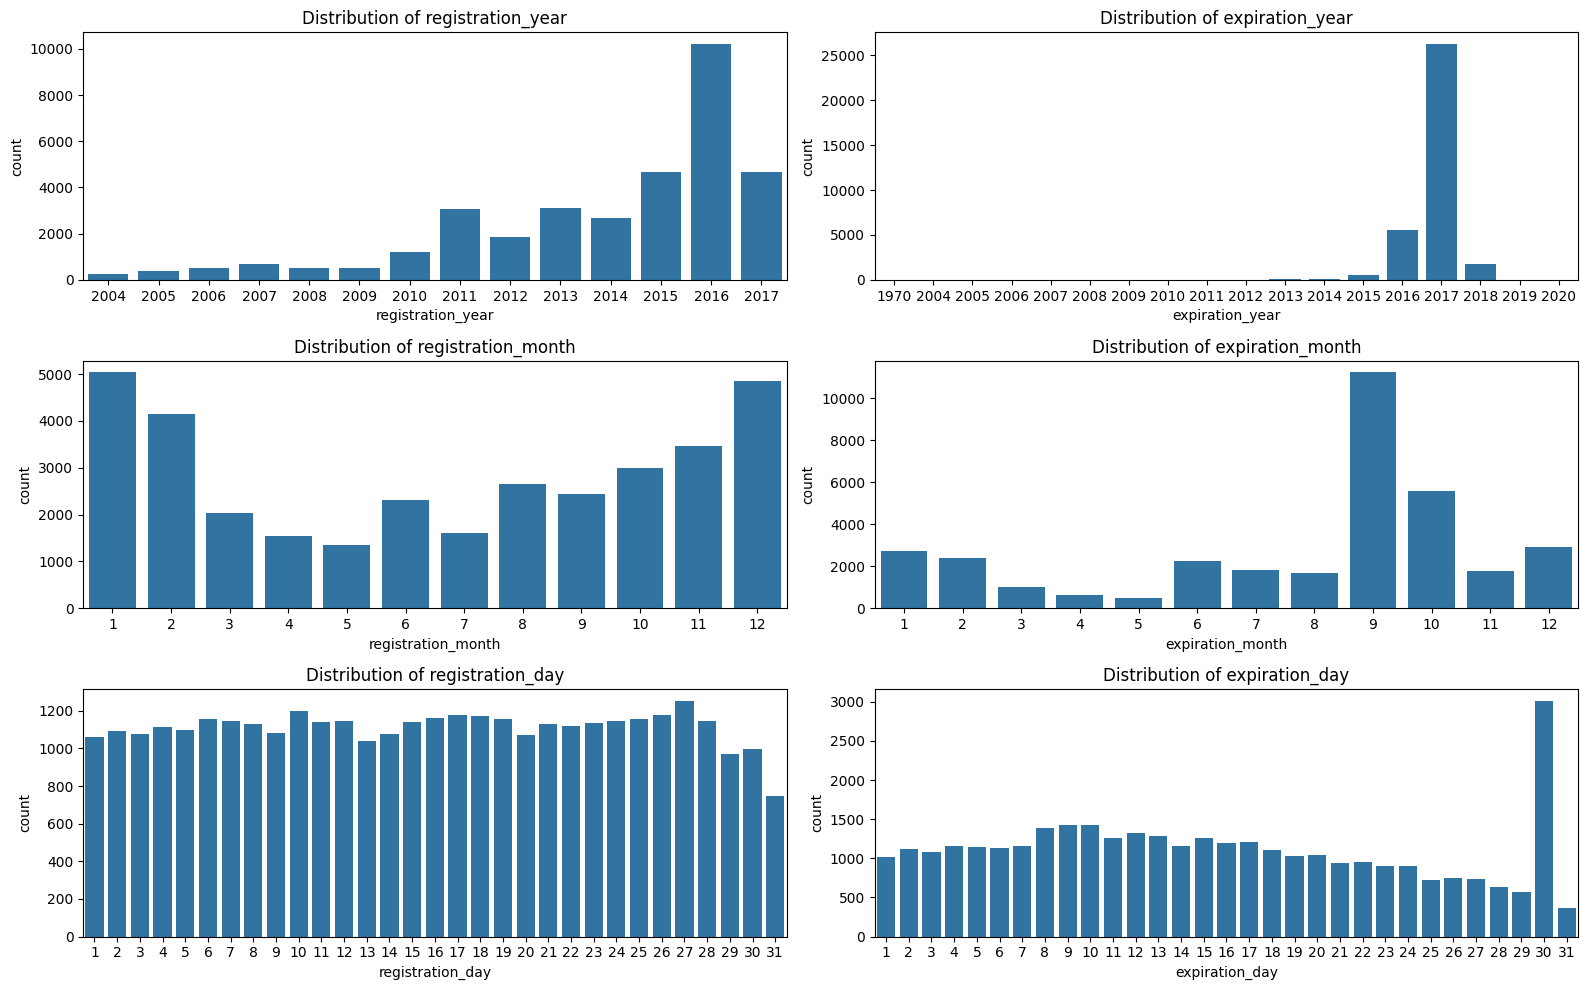

In [59]:
fig, axs = plt.subplots(3, 2, figsize=(16, 10))

plot_0 = sns.countplot(x='registration_year', data=members, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of registration_year')

plot_1 = sns.countplot(x='expiration_year', data=members, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of expiration_year')

plot_2 = sns.countplot(x='registration_month', data=members, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of registration_month')

plot_3 = sns.countplot(x='expiration_month', data=members, ax=axs[1, 1])
axs[1, 1].set_title('Distribution of expiration_month')

plot_4 = sns.countplot(x='registration_day', data=members, ax=axs[2, 0])
axs[2, 0].set_title('Distribution of registration_day')

plot_5 = sns.countplot(x='expiration_day', data=members, ax=axs[2, 1])
axs[2, 1].set_title('Distribution of expiration_day')

plt.tight_layout()
plt.show()

Явных выбросов в месяцах и днях нет.

Что касается года, то `expiration_year` выглядит странно. Есть данные с 1970 года, большинство аккаунтов просрочено в 2017. Даже несмотря на то, что дата регистрации может быть в 2004 году, когда сервиса ещё могло не существовать, это выглядит более логично.

Будем восстанавливать дату истечения по дате регистрации и длительности жизни аккаунта. Запишем результаты сразу в колонки с днём, месяцем и годом.

In [60]:
members['expiration_date'] = members['registration_init_time'] + pd.to_timedelta(members['duration'], unit='d')

members['expiration_year'] = members['expiration_date'].dt.year
members['expiration_month'] = members['expiration_date'].dt.month
members['expiration_day'] = members['expiration_date'].dt.day


members.drop('registration_init_time', axis=1, inplace=True)
members.drop('expiration_date', axis=1, inplace=True)

In [61]:
members.sample(2)

,msno,city,bd,gender,registered_via,duration,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day
24632,syvAtFOuWbKl7U4qBn1SkyTL/eBGtTjea+LemlriMHQ=,5,24,female,7,1079.0,2014,9,27,2017,9,10
22428,BB6AsXSrV2BaHzf/21m3zfCBXIuIQ+Q4f/begMHxlWI=,13,17,male,9,732.0,2015,9,6,2017,9,7


In [62]:
members.drop('duration', axis=1, inplace=True)

Датафрейм практически предобработан. Осталось только сделать one hot encoding для гендера.

In [63]:
members = pd.get_dummies(members, columns=['gender'], drop_first=True)

In [64]:
members.sample(3)

,msno,city,bd,registered_via,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day,gender_male,gender_not_provided
20591,yi96sr3mBunbJ9G2S5r/fDeIes5h1HvJxNp8+RxTjf0=,1,17,4,2016,10,21,2017,5,24,False,True
14830,NIummgi+CoMg5/9nN4Eio/ucoi43wfBcGhqenizhTlY=,1,28,4,2016,6,7,2016,10,30,False,True
33902,wotosl+/6wnZR8zntiHzpSaed5D8Wl0V3dj+NIMgUWM=,1,44,4,2016,3,7,2016,10,4,False,True


## Songs & Info

In [65]:
songs = pd.read_csv('/content/drive/My Drive/vk/music/songs.csv')

In [66]:
info.head(3)

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303


Здесь никакой предобработки сделать мы не сможем, потому что здесь могут встречаться дубликаты во всех колонках, непонятно что считать выбросами. Можно только посмотреть на пустые значения.

In [67]:
info.isnull().sum()

song_id         0
name            3
isrc       136548
dtype: int64

Удалим строки, где название песни пустое. Остальное трогать не будем.

In [68]:
info.dropna(subset=['name'], inplace=True)

Перейдём к другому датафрейму.

In [69]:
songs.head(3)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0


In [70]:
print('Unique Values in Columns:\n\n')

print(f"song_length:\n{songs['song_length'].unique()}\n\n")
print(f"genre_ids:\n{songs['genre_ids'].unique()}\n\n")
print(f"artist_name:\n{songs['artist_name'].unique()}\n\n")
print(f"composer:\n{songs['composer'].unique()}\n\n")
print(f"lyricist:\n{songs['lyricist'].unique()}\n\n")
print(f"language:\n{songs['language'].unique()}")

Unique Values in Columns:


song_length:
[247640 197328 231781 ...  34046 576130 417100]


genre_ids:
['465' '444' '726' ... '786|958|2022' '1259|2107' '1138|2022']


artist_name:
['張信哲 (Jeff Chang)' 'BLACKPINK' 'SUPER JUNIOR' ... 'Charley Brownn'
 'Avaleya and The GlitterHawks' 'Renato pezzella| Renato Pezzella']


composer:
['董貞' 'TEDDY|  FUTURE BOUNCE|  Bekuh BOOM' nan ... 'Mawwell J. Mckinney'
 'Adam Lyons| Nathan Lyons| Timothy Voeten| Patrick Huerto| Thomas Davies| James Haigh'
 'Rodney Clawson| Vicky McGehee| David Lee Murphy']


lyricist:
['何啟弘' 'TEDDY' nan ... 'Otoniel Santos' 'Stepz|Branco'
 'Rodney Clawson| Vicky McGehee| David Lee Murphy']


language:
[ 3. 31. 52. 17. 10. -1. 24. 59. 45. 38. nan]


Исследуем сначала длительность. Заранее посчитаем выбросами всё, что меньше 1 минуты и больше 10 минут.

In [71]:
songs.loc[songs['song_length'] < 60000, 'song_length'] = np.nan
songs.loc[songs['song_length'] > 600000, 'song_length'] = np.nan

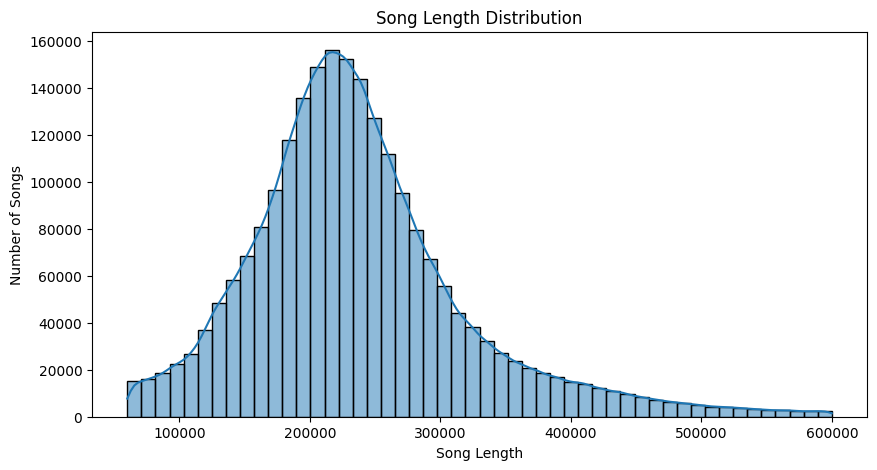

In [72]:
plt.figure(figsize=(10, 5))
sns.histplot(songs['song_length'], bins=50, kde=True)
plt.title('Song Length Distribution')
plt.xlabel('Song Length')
plt.ylabel('Number of Songs')
plt.show()

Получилось очень красивое распределение, похожее на нормальное, если бы мы его не обрезали. Заменим созданные нами пустые значения в соответствии с ним.

In [73]:
len_distribution = songs['song_length'].dropna().value_counts(normalize=True)

n_missing_lens = songs['song_length'].isnull().sum()

songs.loc[songs['song_length'].isnull(), 'song_length'] = sample_value(n_missing_lens, len_distribution)

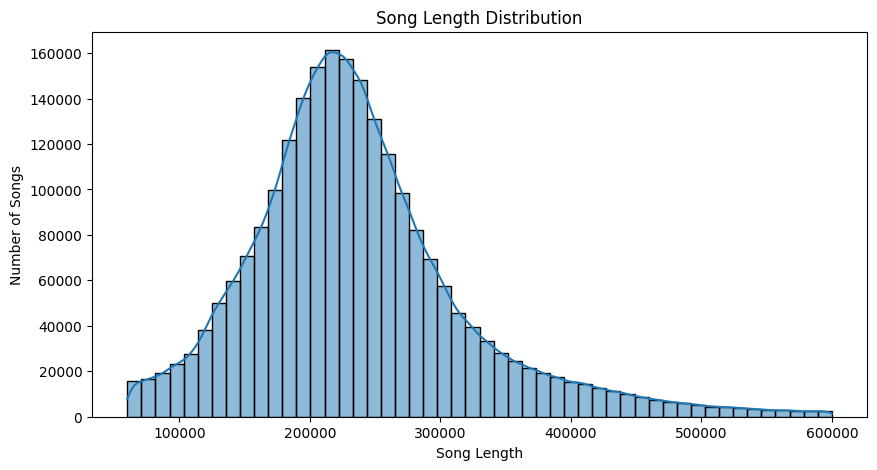

In [74]:
plt.figure(figsize=(10, 5))
sns.histplot(songs['song_length'], bins=50, kde=True)
plt.title('Song Length Distribution')
plt.xlabel('Song Length')
plt.ylabel('Number of Songs')
plt.show()

Далее поработаем с жанрами.

In [75]:
songs['genre_ids'].nunique()

1045

Разных жанров очень много, но здесь не учитывается, что в одной строке может быть любая комбинация из нескольких id. Учтём это и посчитаем ещё раз.

In [76]:
unique_genres = set()

for genres in songs['genre_ids'].dropna().unique():
    unique_genres.update(genres.split('|'))

num_unique_genres = len(unique_genres)

print(num_unique_genres)


191


Их стало значительно меньше, но всё ещё довольно много. Вряд ли нам нужно столько дополнительных фичей, поэтому для каждой строки, если там встретилось несколько жанров, оставляем только первый.

То же самое проделываем с артистом, композитором и автором текста.

In [77]:
songs['genre_ids'] = songs['genre_ids'].str.split('|', expand=True)[0]

songs['artist_name'] = songs['artist_name'].str.split('|', expand=True)[0]

songs['composer'] = songs['composer'].str.split('|', expand=True)[0]

songs['lyricist'] = songs['lyricist'].str.split('|', expand=True)[0]

Если же где-то нет композитора, автора текста или артиста - заменим на того, кто в этой строке есть (приоритетно - артист, потом композитор и потом уже автор текста). Если никого нет, эту строку можно удалить.

In [78]:
songs['artist_name'].fillna('unknown', inplace=True)
songs['composer'] = songs.apply(
    lambda x: x['artist_name'] if pd.isna(x['composer']) else x['composer'],
    axis=1
)
songs['lyricist'] = songs.apply(
    lambda x: x['composer'] if pd.isna(x['lyricist']) else x['lyricist'],
    axis=1
)

songs.dropna(subset=['artist_name', 'composer', 'lyricist'], how='all', inplace=True)

In [79]:
songs.sample()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
922115,QYdmi0Zx8aVosrRmOREp4CP6XGtg9Qazu3H81IlvB34=,481767.0,1152,Jignesh Kaviraj,Ranjit Nadiya,Ranjit Nadiya,-1.0


Последнее - посмотрим на язык.

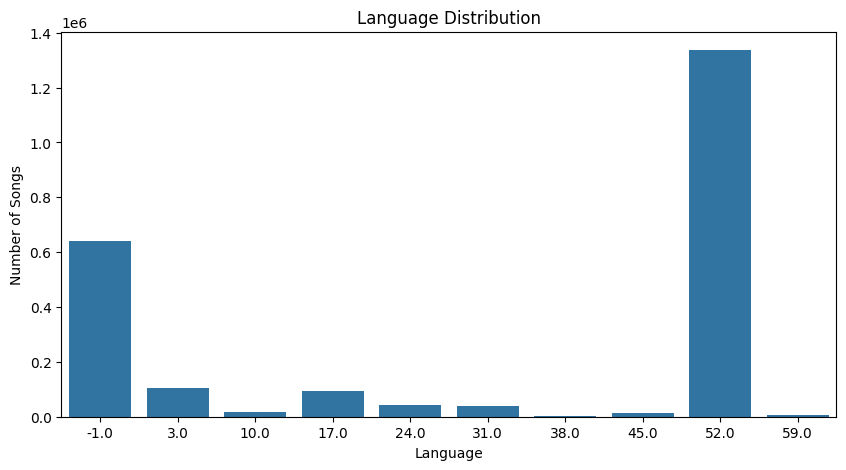

In [80]:
plt.figure(figsize=(10, 5))
sns.countplot(x='language', data=songs)
plt.title('Language Distribution')
plt.xlabel('Language')
plt.ylabel('Number of Songs')
plt.show()

Здесь не будем ничего делать, даже несмотря на то, что есть очень мало используемые языки и непонятный -1, который почему-то решили закодировать отрицательным числом (вероятно, это смесь языков, неизвестный язык или "другое").

На этом остановимся с предобработкой.

# Feature Engineering, Model Building & Training

Объединим в train все столбцы, которые нам нужны.

In [81]:
train = train.merge(songs, on='song_id', how='left')
train = train.merge(members, on='msno', how='left')

In [82]:
train.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,bd,registered_via,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day,gender_male,gender_not_provided
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,1,5,4,1,206471.0,359,Bastille,Dan Smith,...,29,7,2012,1,2,2017,10,5,False,True
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,3,6,3,1,284584.0,1259,Various Artists,Various Artists,...,24,9,2011,5,25,2017,9,11,False,False
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,3,6,3,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,24,9,2011,5,25,2017,9,11,False,False


In [83]:
train.dtypes

msno                    object
song_id                 object
source_system_tab        int64
source_screen_name       int64
source_type              int64
target                   int64
song_length            float64
genre_ids               object
artist_name             object
composer                object
lyricist                object
language               float64
city                     int64
bd                       int64
registered_via           int64
registration_year        int32
registration_month       int32
registration_day         int32
expiration_year          int32
expiration_month         int32
expiration_day           int32
gender_male               bool
gender_not_provided       bool
dtype: object

У нас есть 4 столбца формата object. Жанры просто превратим в числа (потому что это числа), с остальными сделаем label encoding.

In [84]:
train['genre_ids'] = train['genre_ids'].fillna(train['genre_ids'].mode()[0]).astype('int')

In [85]:
train['artist_name'] = label_encoder.fit_transform(train['artist_name'].astype(str))
train['composer'] = label_encoder.fit_transform(train['composer'].astype(str))
train['lyricist'] = label_encoder.fit_transform(train['lyricist'].astype(str))

Теперь все фичи готовы, чтобы делать из них датасет для модели и подавать ей на вход.

Создадим тренировочный и валидационный датасеты (валидационный - для оценки метрик). Всё это возьмём из датафрейма train.

In [86]:
features = [col for col in train.columns if col not in ['target', 'msno', 'song_id']]

In [87]:
X = train[features]
y = train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1
}

В качестве модели выбран градиентный бустинг на решающих деревьях из фреймворка LightGBM.

Так как нужно предсказывать бинарный таргет, будем рассматривать построение рекомендательной системы как задачу бинарной классификации. Для этих целей в качестве лосс-функции был выбран бинарный LogLoss.

In [89]:
gbm = lgb.train(params, train_data, num_boost_round=100, valid_sets=[train_data, val_data])

In [90]:
y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)

На валидационном датасете рассчитаем метрику NDCG@20.

In [91]:
ndcg_val = ndcg_score([y_val], [y_pred], k=20)
print(f"NDCG@20 on validation set: {ndcg_val}")

NDCG@20 on validation set: 0.9644899900915855


У нас получились хорошие результаты.

Также сделаем предсказания на тестовом датасете и посмотрим на них.

In [94]:
test = test.merge(songs, on='song_id', how='left')
test = test.merge(members, on='msno', how='left')

In [95]:
test['genre_ids'] = test['genre_ids'].fillna(test['genre_ids'].mode()[0]).astype('int')

In [96]:
test['artist_name'] = label_encoder.fit_transform(test['artist_name'].astype(str))
test['composer'] = label_encoder.fit_transform(test['composer'].astype(str))
test['lyricist'] = label_encoder.fit_transform(test['lyricist'].astype(str))

In [97]:
X_test = test.drop(columns=['msno', 'song_id'])

In [99]:
X_test = X_test.drop(columns=['id'])

In [100]:
X_test.head()

,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,registered_via,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day,gender_male,gender_not_provided
0,3,6,2,224130.0,458,24299,29245,28659,3.0,1,24,7,2016,2,19,2017,9,18,False,True
1,3,6,2,320470.0,465,24152,44592,42203,3.0,1,24,7,2016,2,19,2017,9,18,False,True
2,0,9,7,315899.0,2022,21314,39091,38384,17.0,1,15,4,2016,11,17,2019,1,23,False,True
3,4,11,5,285210.0,465,20184,35242,34587,52.0,3,30,9,2007,7,25,2008,8,25,True,False
4,4,11,5,197590.0,873,21199,26709,26205,-1.0,3,30,9,2007,7,25,2008,8,25,True,False


In [101]:
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [ ]:
test['target'] = y_pred_test

In [ ]:
test.target = test.target > 0.5

In [111]:
test.target = test.target.astype('int')

In [112]:
test.sample(5)

,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,...,registered_via,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day,gender_male,gender_not_provided,target
1704418,1711781,NapSQ9C9tjbMFO34ODka2ws688+wFrxwXpyeCr83u5Q=,ZXW6Df8q6jp6cUWCM6hFTAG/3PrqUZ2j5cBobvszX6E=,0,2,4,265914.0,921,24884,1286,...,3,2013,9,7,2017,9,27,True,False,1
2401249,2411444,2HR/JizLgyX4Mi5+WgG5Y0kOe9Uz/7wVaeBhyPdFZ6E=,ixysau9+h1JJL4Lx2cyppSb/EH44YCHtc/2x7zAU1zA=,4,11,5,288078.0,465,22610,42599,...,7,2013,2,19,2017,9,17,False,False,0
2369319,2379399,wcpspaw6+dFR9R2y0T9oUSwmB+ZS2Fi8U3KCnbSdFT4=,mDaUXcHK4yJqolXYXNvtwNoFNV1hxNaarsAwWMW2n0c=,3,6,2,240013.0,465,22503,49193,...,9,2010,7,23,2011,4,29,False,True,1
2047836,2056605,ESPKQfbLY3DNYScbz6urG/6S102TWGSUXTu1IdM27Yg=,2MRXrIB8hS/wlIIfCI0zOofjWh00gIPcY7U0nkvt0Do=,3,6,2,282749.0,465,23564,988,...,7,2014,6,15,2017,9,30,True,False,1
477818,479952,OtoN9o6WYB5Ua/K8Dhd3Mlb92ZPdpkCcdXL7wwVMAnU=,a9Y5ruC8RyyjAYI1yRfr74aedmfJDGC1bDUAMLktYBc=,3,1,8,160496.0,465,16521,12782,...,7,2016,1,17,2017,9,16,True,False,0


In [113]:
test.to_csv('/content/test_predicts.csv')